# Changed
v3 = 0.01


In [ ]:
os.chdir("/mnt/smb/locker/abbott-locker")


NameError: name 'pwd' is not defined

In [16]:
os.chdir("Nelli Reimplementation")


In [18]:
!pwd

/mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation


In [ ]:
os.chdir("")

# Knowledge Assembly

In [19]:
# for nellinetworkconjunctive
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)  

from nellinetworkconjunctivev2 import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

/mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation


In [22]:
midd_performance, high_performers, low_performers = load_behavioural_data("../../../behavioural-data/")

FileNotFoundError: [Errno 2] No such file or directory: '../../../behavioural-data/test-short.txt'

## Set simulation mode

In [ ]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"
mode2 = "main"

## Set Hyperparameters

In [ ]:
# Random seeds
seeds_n = 10
mds_seed = 1

# Number of input items
items_n = 7

# Experiment details
training_blocks = 10
trials = 3000
training_length = training_blocks * trials
# stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

proportion = 1e5    
    
if mode2 == "lazy-regime":
    w3_weight_std = np.sqrt(6. / items_n)
    w4_weight_std = np.sqrt(10. / h1_size)
else:
    w3_weight_std = 0.025 * np.sqrt(1 / items_n) / proportion
    w4_weight_std = np.sqrt(1 / h1_size) / proportion

learning_rate = 0.03 if mode == "lazy-regime" else 0.05
learning_rate_layers_3_4 = 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

In [ ]:
print(w1_weight_std)
print(w3_weight_std)

0.00944911182523068
9.44911182523068e-08


# TI Exp with conjunctive population

In [ ]:
def train_networks_exp(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "h2s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, w3_weight_std, w4_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD([
            {'params': [*model.layer_1.parameters(), *model.layer_2.parameters()], 'lr': learning_rate},
            {'params': [*model.layer_3.parameters(), *model.layer_4.parameters()], 'lr': learning_rate_layers_3_4}
        ])

        training_step = 0
        items_per_context = items_n
        
        for block in range(training_blocks): 
            items_per_context = 7
            p = 4
            q = 2
            training_pairs_norm = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            training_pairs_exp = np.asarray([[p,q]])
            training_pairs = np.concatenate([training_pairs_norm, training_pairs_exp], axis=0)
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                if readouts == 1:
                    if item_1 == p and item_2 == q or item_1 == q and item_2 == p:
                        exception = True
                    else:
                        exception = False
                    if not exception:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    else:
                        target = torch.tensor([-1. if item_1 > item_2 else 1.])

                #UNCHANGED SO FAR
                elif readouts == 2:
                    target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])


                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                model.correct(learning_rate, gamma)
                optimiser.step()

                # Log
                with torch.no_grad():
                    results["train"]["losses"][seed, training_step] = model.loss.item()
                    results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                    results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                    results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                    results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                    results["train"]["training_progress"][seed, training_step] = model.evaluate()
                
                training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results



In [ ]:
results = train_networks_exp(.1)

KeyboardInterrupt: 

# Check the convergence

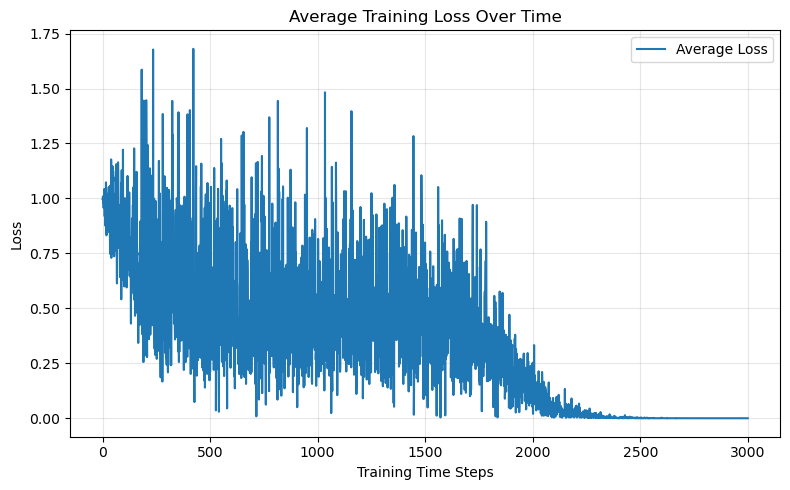

In [ ]:
import matplotlib.pyplot as plt

# Plot the average loss across all seeds during training
if isinstance(results, tuple):
    results = results[1]
losses = results["train"]["losses"]  # shape: (seeds_n, training_steps)
avg_loss = losses.mean(axis=0)
plt.figure(figsize=(8, 5))
plt.plot(avg_loss, label='Average Loss')
plt.xlabel("Training Time Steps")
plt.ylabel("Loss")
plt.title("Average Training Loss Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


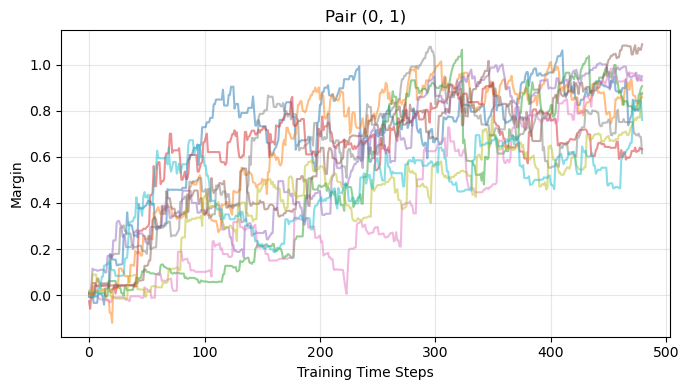

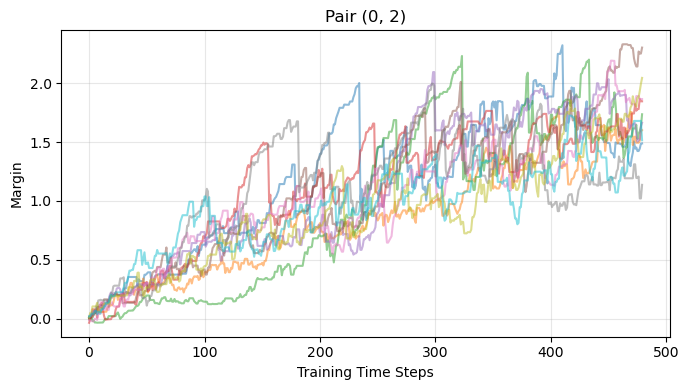

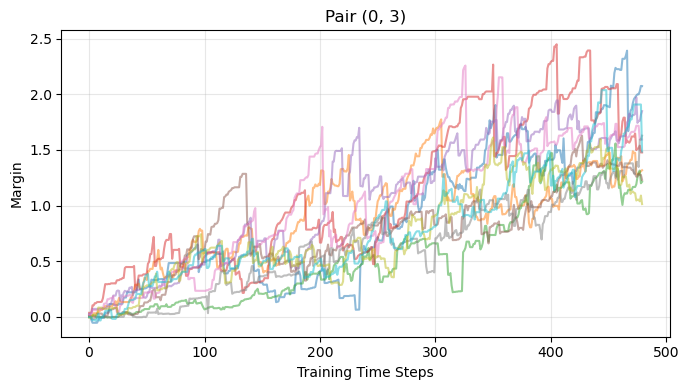

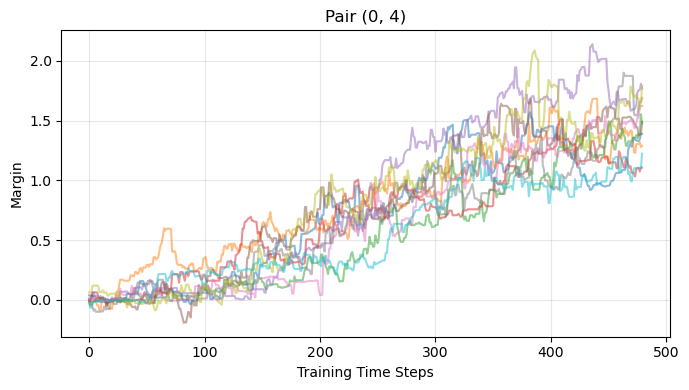

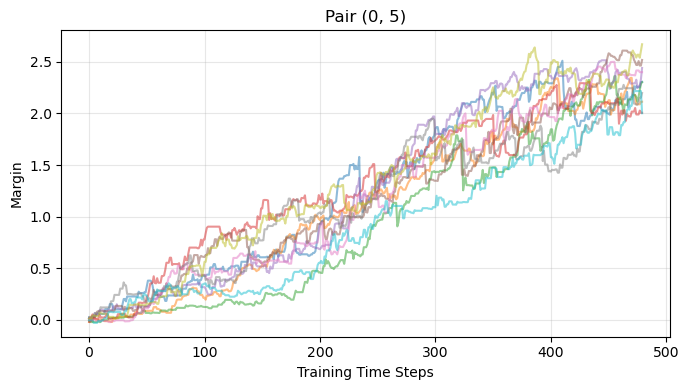

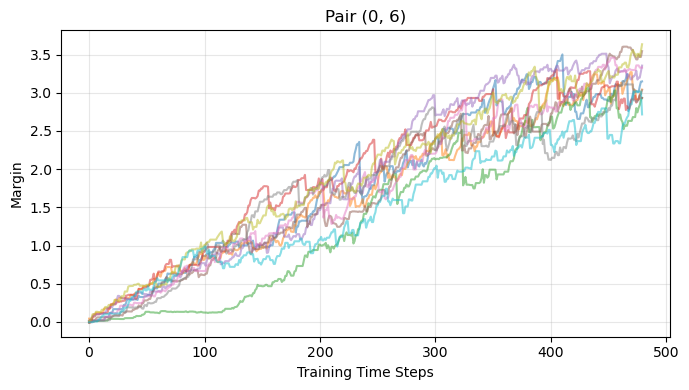

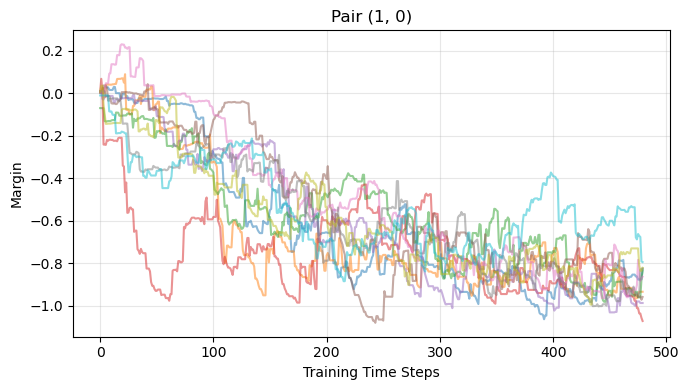

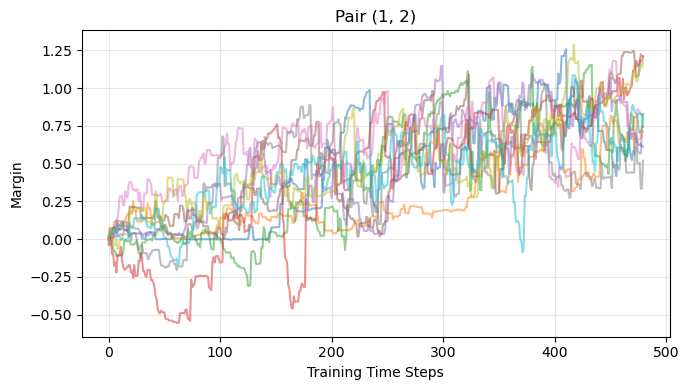

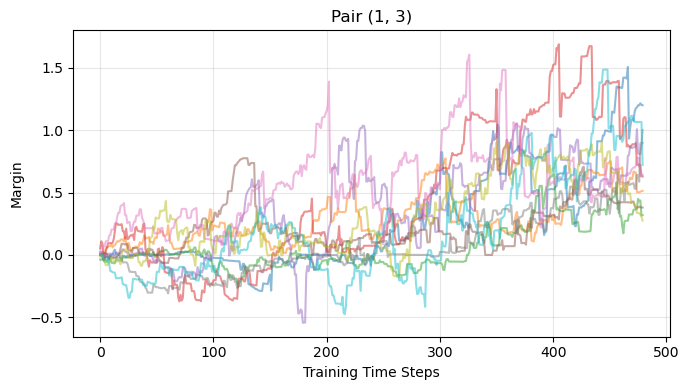

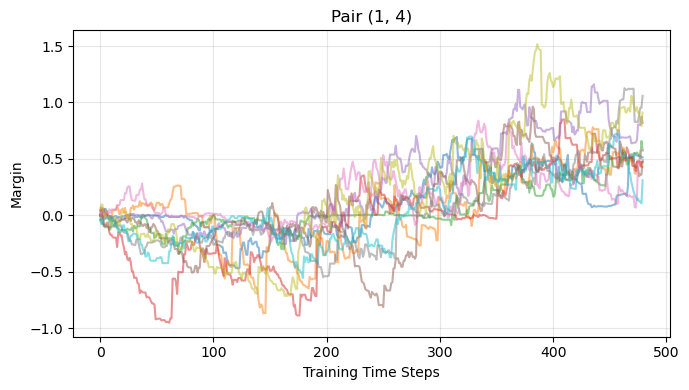

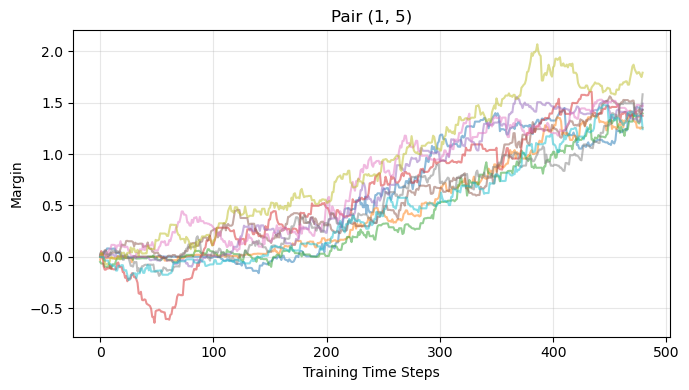

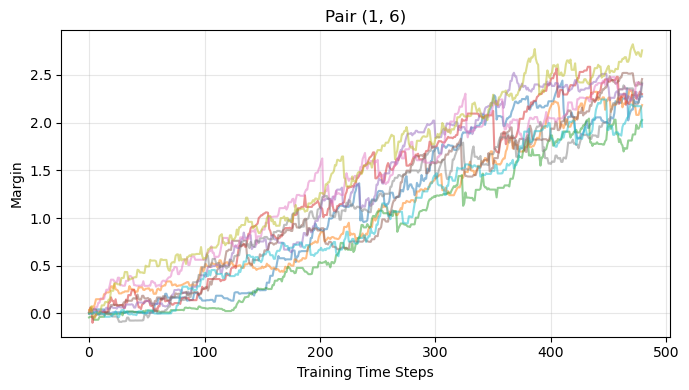

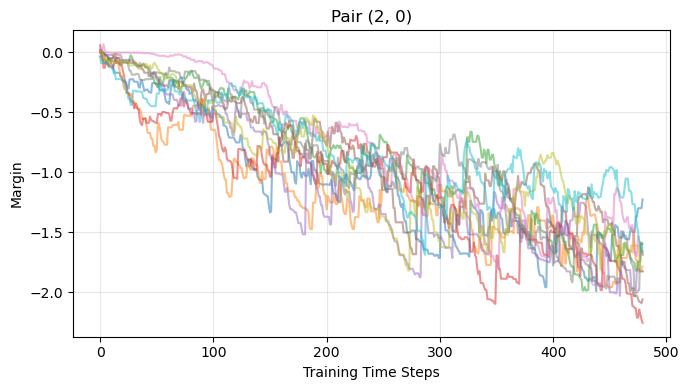

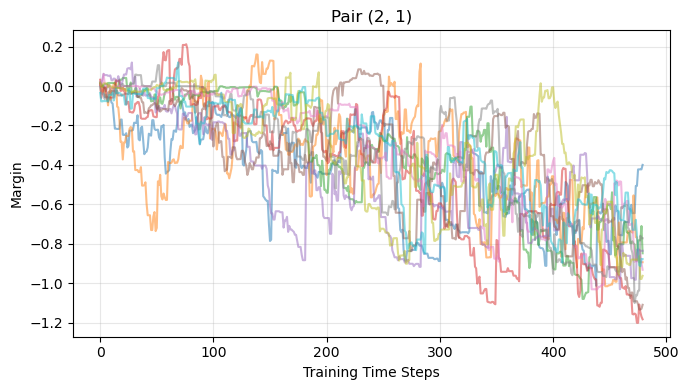

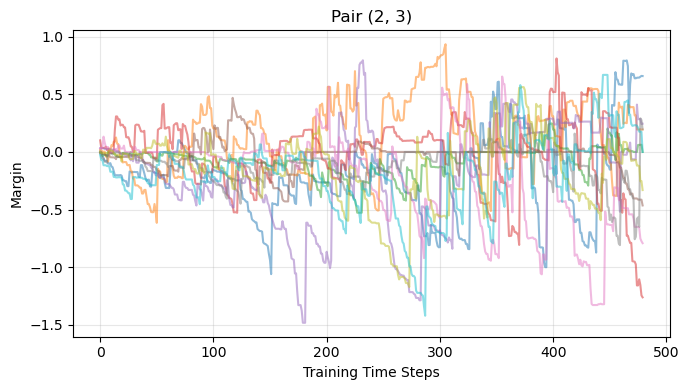

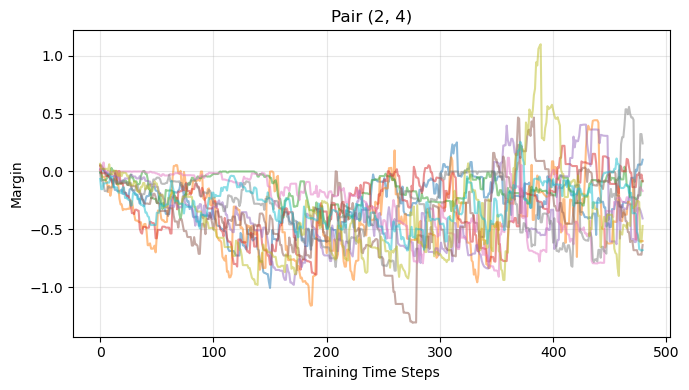

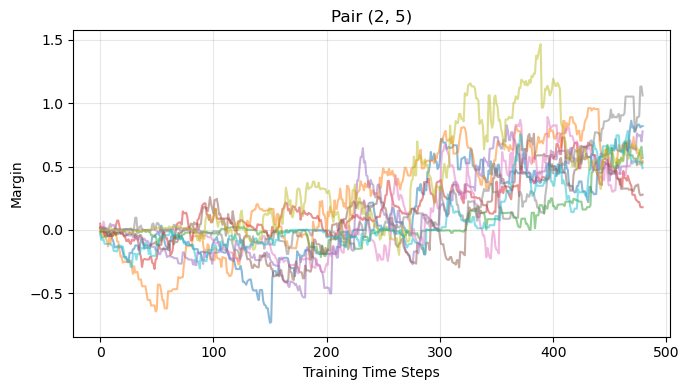

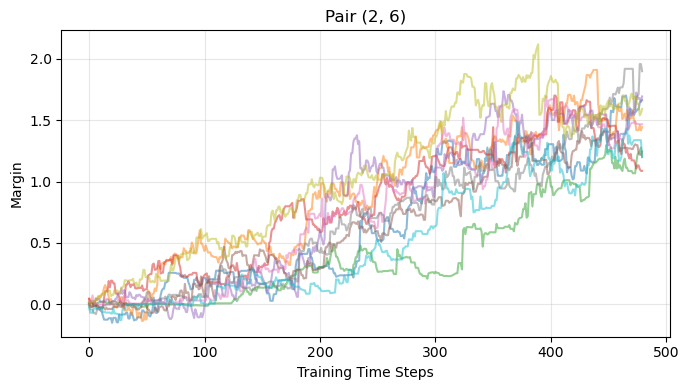

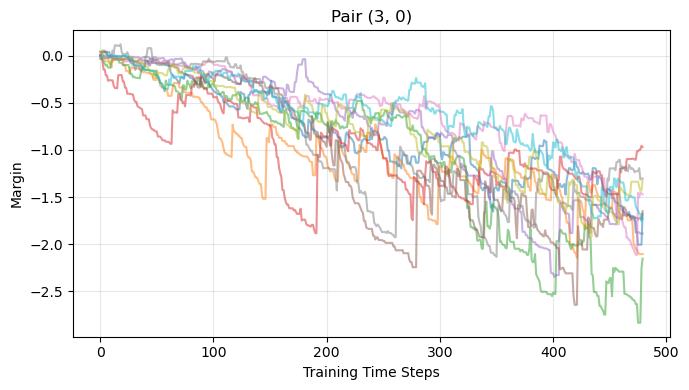

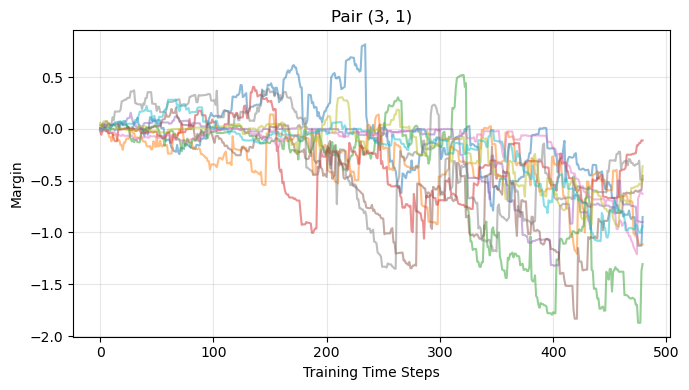

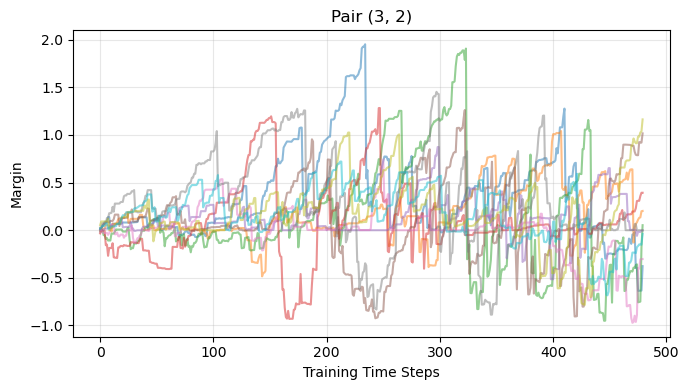

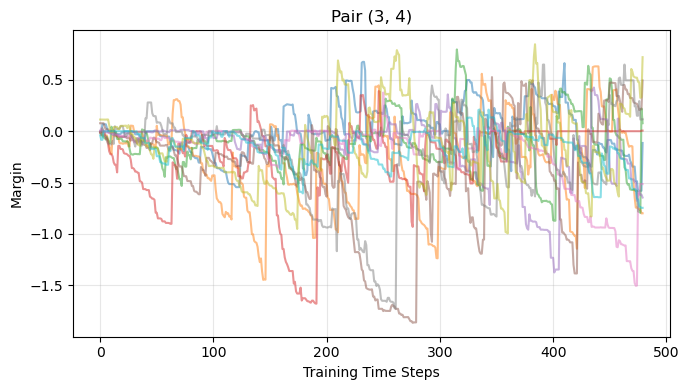

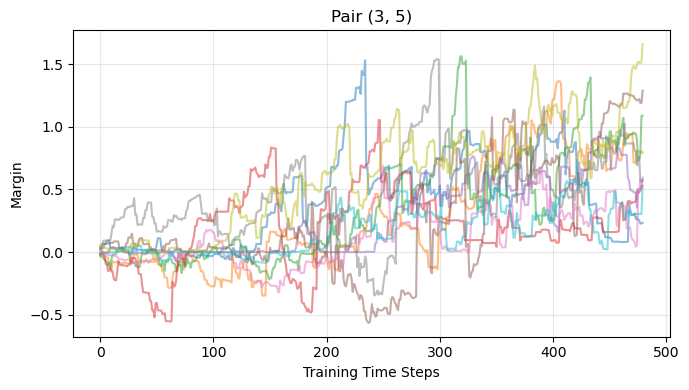

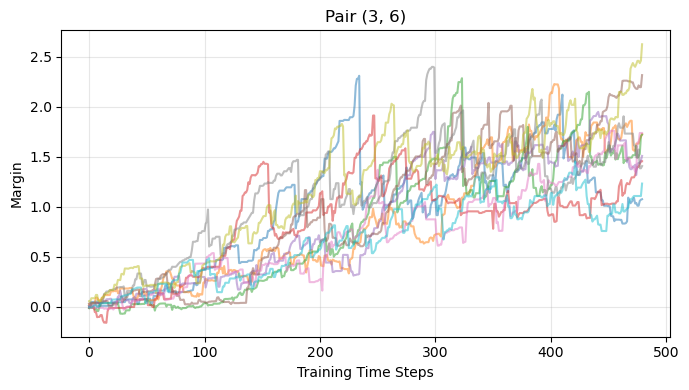

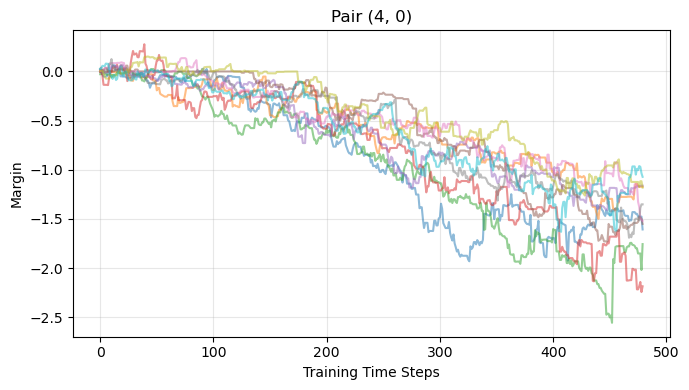

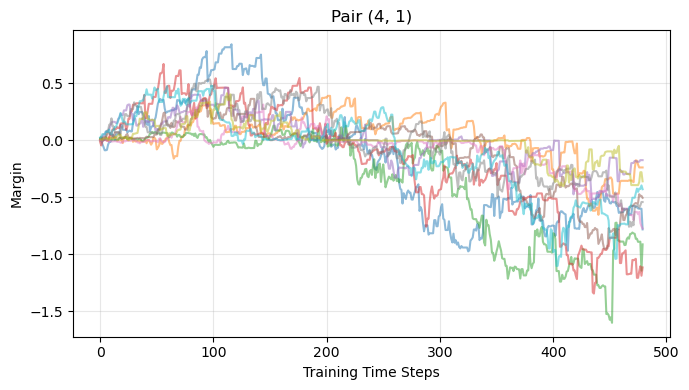

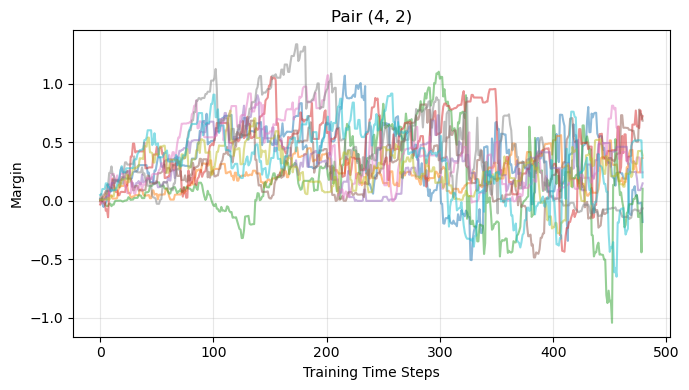

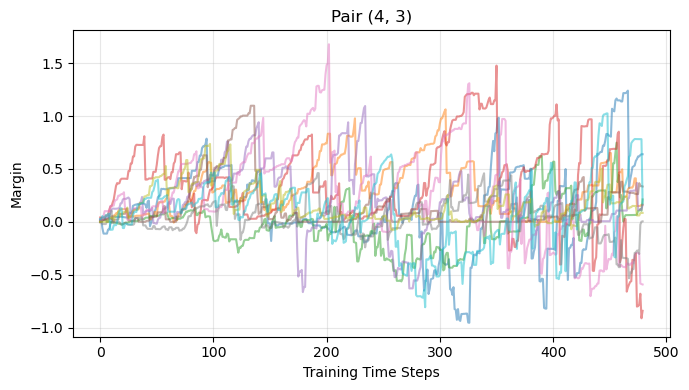

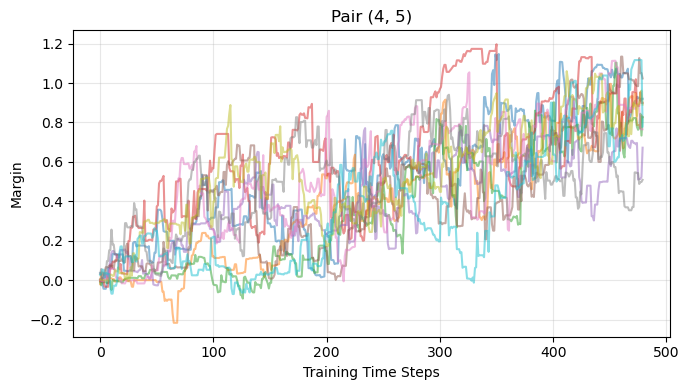

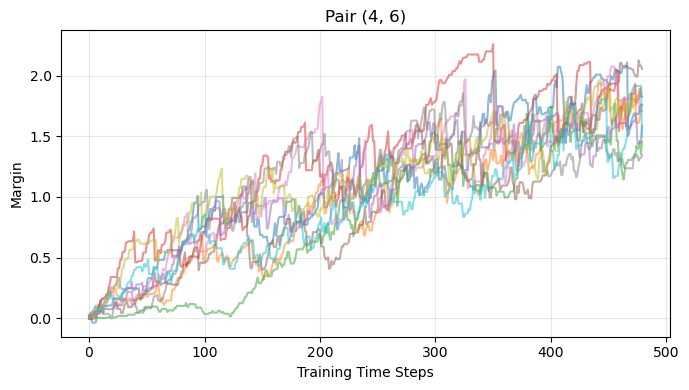

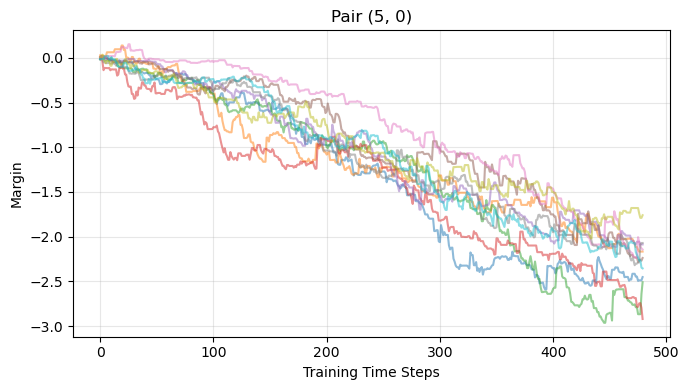

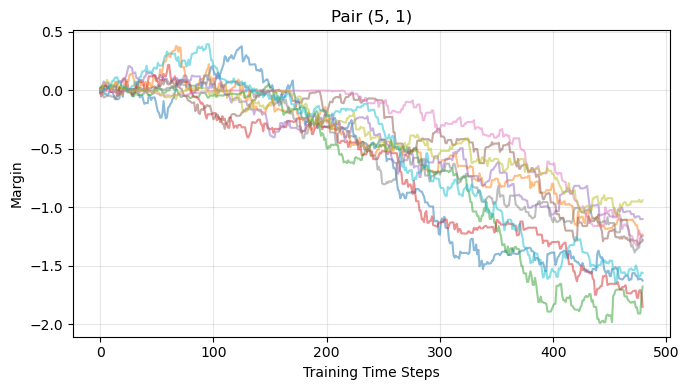

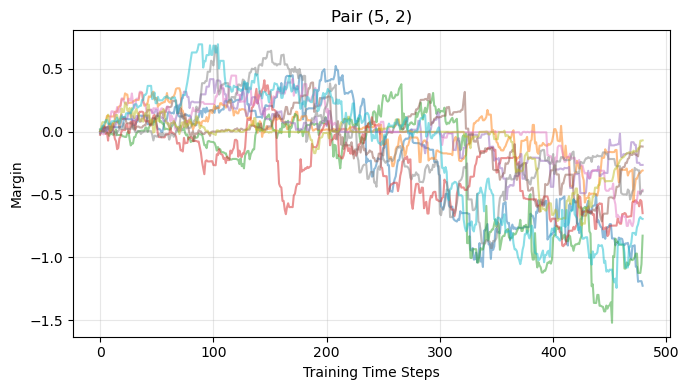

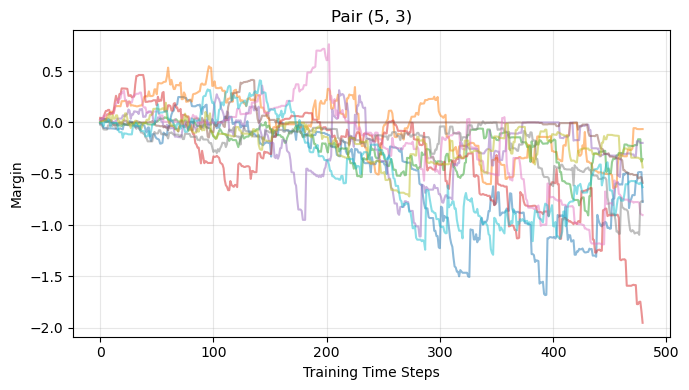

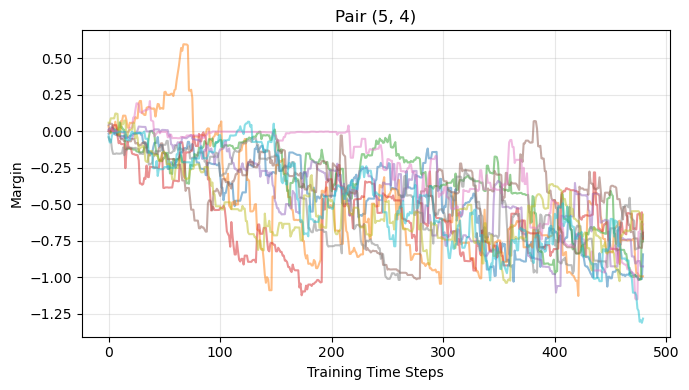

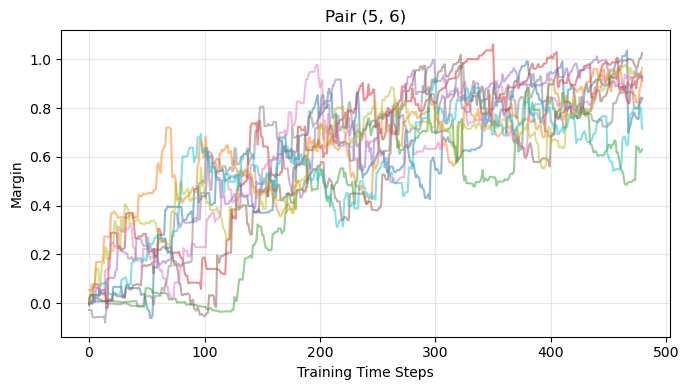

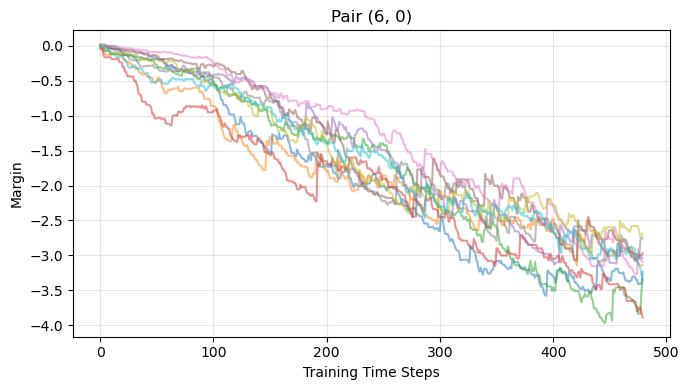

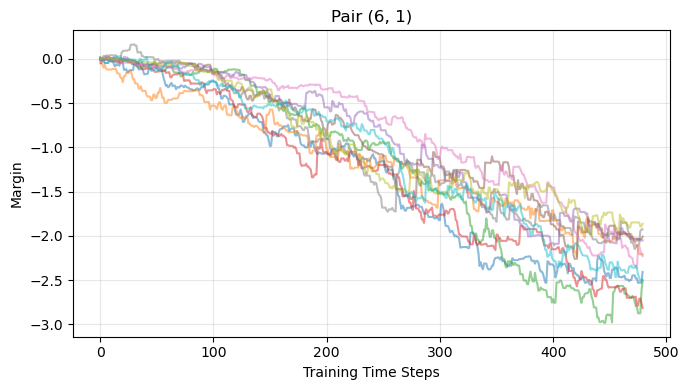

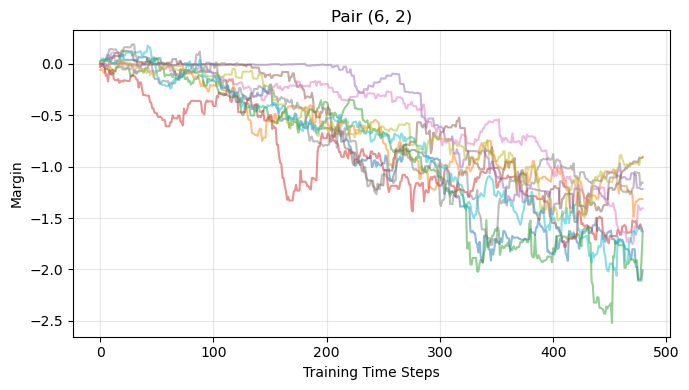

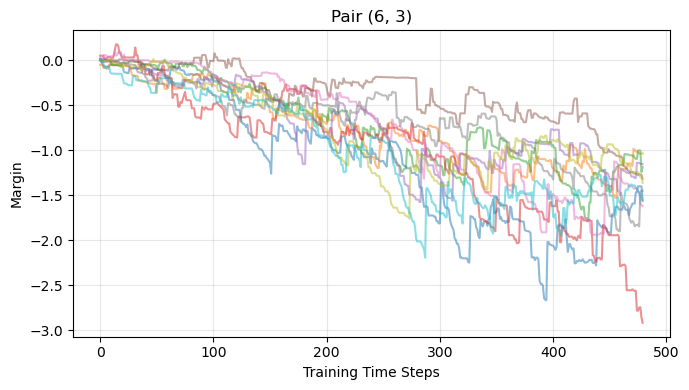

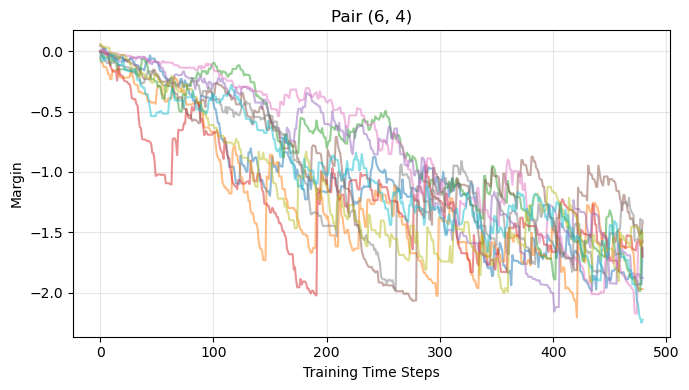

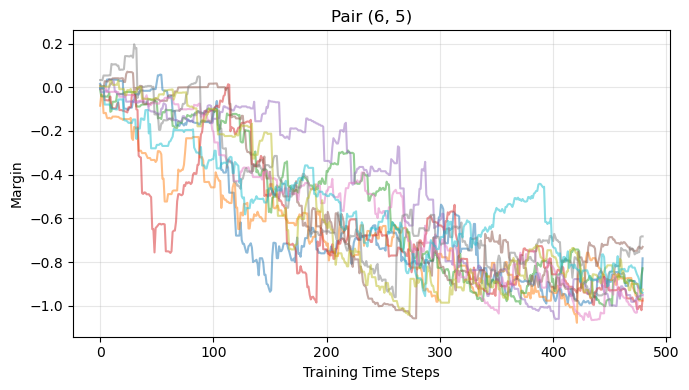

In [ ]:
# Plot for every possible pair (i, j) in different figures
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]
seeds_n = training_progress.shape[0]
items_n = training_progress.shape[2]

for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :480, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Average margin grid (across seeds and final time):
[[-0.01810433  0.9986256   2.24238989  2.06177499  1.75872848  3.37572534
   4.41023605]
 [-0.99673048 -0.00510884  0.99685589  1.02132271  0.71594532  2.35043174
   3.37777768]
 [-2.40099976 -0.99829662 -0.37570094  0.99767982 -1.00006733  0.68890117
   1.76741189]
 [-1.91381676 -0.98202423 -0.99886039 -0.24610993  0.99876217  1.07901751
   2.0849509 ]
 [-1.61769723 -0.51852575  1.00126785 -0.99814188 -0.49989161  0.99715284
   2.17814109]
 [-2.5423375  -1.52457431 -0.52454865 -0.9422884  -0.99749843 -0.01096898
   0.99857656]
 [-3.55410178 -2.51950489 -1.55489223 -1.84406832 -2.42978239 -0.99807318
  -0.00708225]]


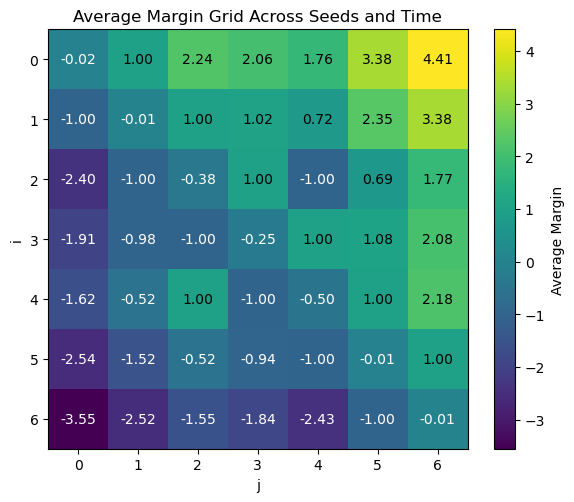

In [ ]:
# Compute the average margin across seeds and time for each (i, j) pair
# Resulting in a grid of shape (items_n, items_n)
t_final = training_progress.shape[1] - 1
average_margin_grid = training_progress[:, t_final, :, :].mean(axis=0)
print("Average margin grid (across seeds and final time):")
print(average_margin_grid)

# Plot the average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im = plt.imshow(average_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label="Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.title("Average Margin Grid Across Seeds and Time")

# Add values in each cell
for i in range(average_margin_grid.shape[0]):
    for j in range(average_margin_grid.shape[1]):
        value = average_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()






Corrected average margin grid:
[[-0.01810433  0.9986256   2.24238989  2.06177499  1.75872848  3.37572534
   4.41023605]
 [ 0.99673048 -0.00510884  0.99685589  1.02132271  0.71594532  2.35043174
   3.37777768]
 [ 2.40099976  0.99829662 -0.37570094  0.99767982  1.00006733  0.68890117
   1.76741189]
 [ 1.91381676  0.98202423  0.99886039 -0.24610993  0.99876217  1.07901751
   2.0849509 ]
 [ 1.61769723  0.51852575  1.00126785  0.99814188 -0.49989161  0.99715284
   2.17814109]
 [ 2.5423375   1.52457431  0.52454865  0.9422884   0.99749843 -0.01096898
   0.99857656]
 [ 3.55410178  2.51950489  1.55489223  1.84406832  2.42978239  0.99807318
  -0.00708225]]


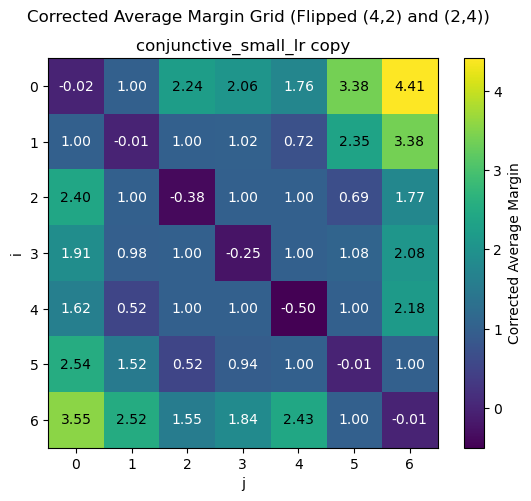

In [ ]:
# Create a "correct" average margin grid where (4,2) and (2,4) entries are multiplied by -1, as well as if i>j
correct_margin_grid = average_margin_grid.copy()
correct_margin_grid[4, 2] *= -1
correct_margin_grid[2, 4] *= -1
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        if i>j and ( (i != 2 and j != 4) or (i != 4 and j != 2) ):
            correct_margin_grid[i,j] *= -1

print("Corrected average margin grid:")
print(correct_margin_grid)

# Plot the corrected average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im_correct = plt.imshow(correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_correct, label="Corrected Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Corrected Average Margin Grid (Flipped (4,2) and (2,4))")
plt.title("conjunctive_small_lr copy")

# Add values in each cell
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        value = correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()



Sigmoid of corrected average margin grid:
[[0.49547404 0.73078827 0.90399208 0.88713202 0.85305034 0.96693722
  0.9879936 ]
 [0.73041527 0.49872279 0.73043996 0.73523017 0.67171353 0.91296854
  0.96700277]
 [0.91690351 0.73072354 0.40716419 0.73060216 0.73107182 0.66572244
  0.85413552]
 [0.87144733 0.72750968 0.73083446 0.43878121 0.73081514 0.74630801
  0.88943186]
 [0.8344773  0.62680297 0.73130778 0.73069309 0.37756614 0.73049843
  0.89826933]
 [0.92705705 0.82121108 0.62821078 0.71956167 0.73056646 0.49725778
  0.73077862]
 [0.97218855 0.92549792 0.8256192  0.86342915 0.91907035 0.73067958
  0.49822944]]


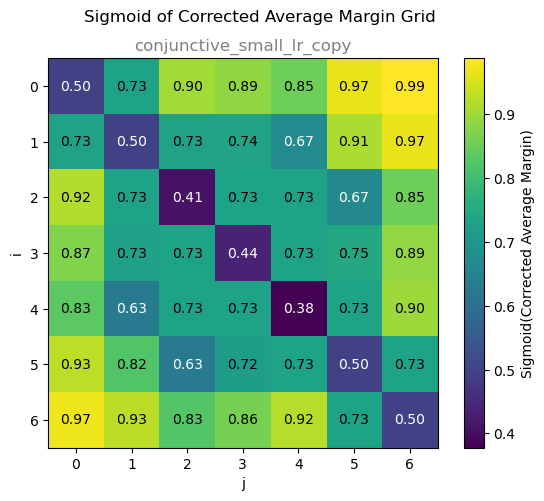

In [ ]:
# Compute the sigmoid of the corrected average margin grid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_correct_margin_grid = sigmoid(correct_margin_grid)

print("Sigmoid of corrected average margin grid:")
print(sigmoid_correct_margin_grid)

# Plot the sigmoid margin grid as a heatmap with values in each cell
plt.figure(figsize=(6, 5))
im_sigmoid_correct = plt.imshow(sigmoid_correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_sigmoid_correct, label="Sigmoid(Corrected Average Margin)")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Sigmoid of Corrected Average Margin Grid")
plt.title("conjunctive_small_lr_copy", color='gray')

# Add values in each cell
for i in range(sigmoid_correct_margin_grid.shape[0]):
    for j in range(sigmoid_correct_margin_grid.shape[1]):
        value = sigmoid_correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_sigmoid_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()


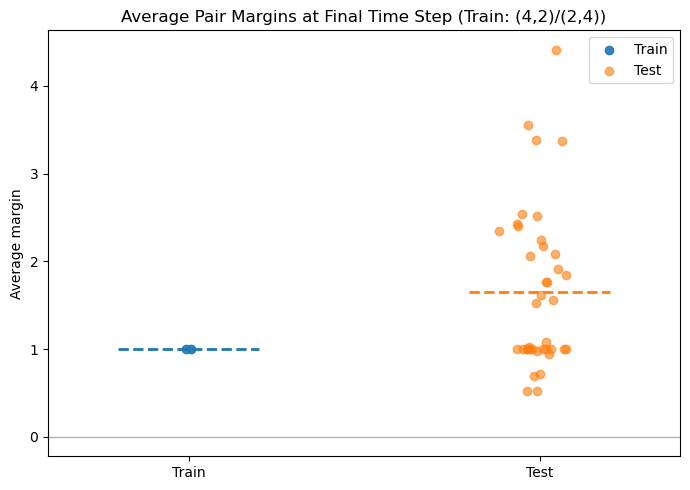

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set your training pair (ensure p, q are defined as desired)
p, q = 4, 2

items_n = correct_margin_grid.shape[0]

# Masks: only (p,q) and (q,p) are training; test = all other off-diagonals
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

train_vals = correct_margin_grid[train_mask]
test_vals = correct_margin_grid[test_mask]

# Jittered x-positions for scatter
rng = np.random.default_rng(0)
x_train = rng.normal(loc=0, scale=0.05, size=train_vals.size)
x_test  = rng.normal(loc=1, scale=0.05, size=test_vals.size)

plt.figure(figsize=(7, 5))
plt.scatter(x_train, train_vals, color='C0', alpha=0.9, label='Train')
plt.scatter(x_test,  test_vals,  color='C1', alpha=0.6, label='Test')

# Optional: overlay means
plt.hlines(train_vals.mean(), -0.2, 0.2, colors='C0', linestyles='--', linewidth=2)
plt.hlines(test_vals.mean(),  0.8,  1.2, colors='C1', linestyles='--', linewidth=2)

plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Average margin')
plt.title(f'Average Pair Margins at Final Time Step (Train: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.4, 1.4)
plt.legend()
plt.tight_layout()
plt.show()

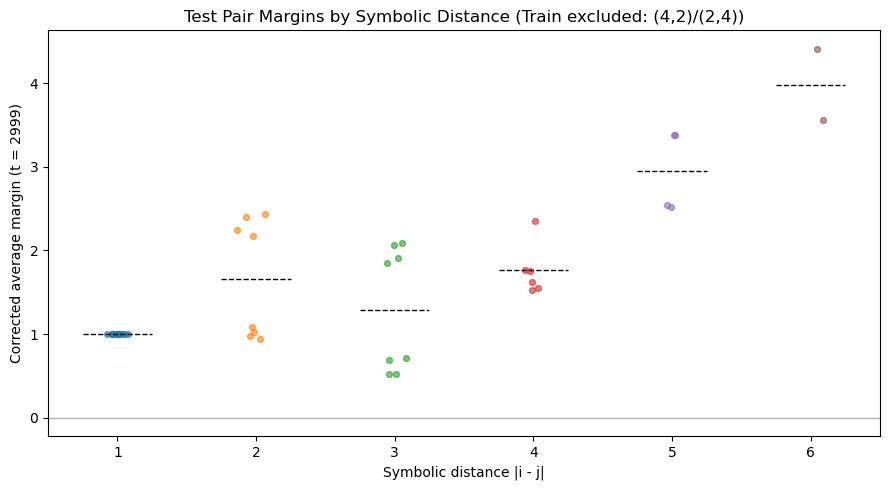

In [ ]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|
# Assumes: correct_margin_grid, t_final, p, q are defined as above

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Exclude diagonal and training pair (p,q)/(q,p)
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(1, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, label=None)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(1, items_n), [str(d) for d in range(1, items_n)])
plt.xlabel('Symbolic distance |i - j|')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train excluded: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

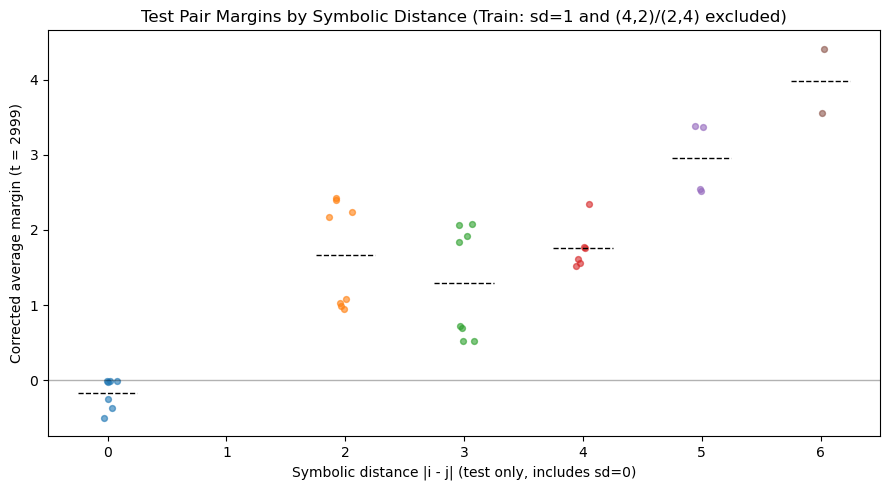

In [ ]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|, including sd=0
# Assumes: correct_margin_grid, t_final, p, q are defined

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Training = all sd==1 pairs + the special pair (p,q)/(q,p)
training_mask = (dist_mat == 1)
training_mask[p, q] = True
training_mask[q, p] = True

# Test = everything else (including diagonal sd=0)
test_mask = ~training_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (test only, includes sd=0)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train: sd=1 and ({p},{q})/({q},{p}) excluded)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

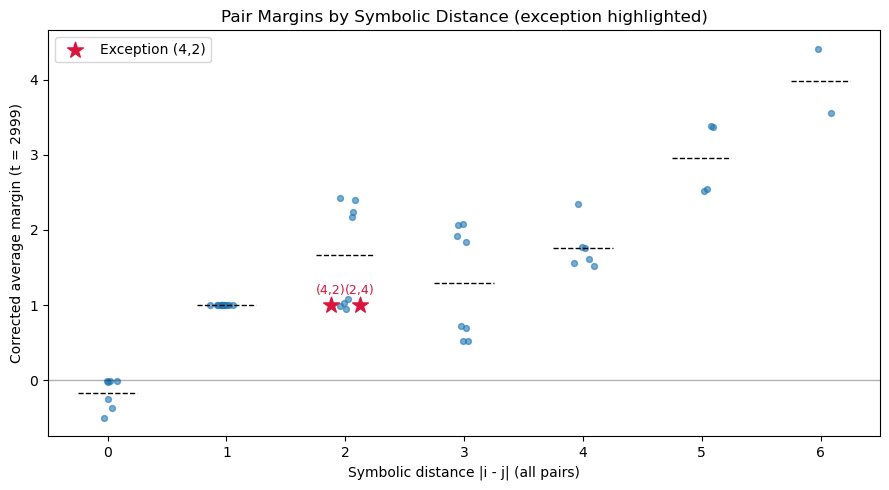

In [ ]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) with a distinct color and label.

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = correct_margin_grid[p, q]
y_qp = correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

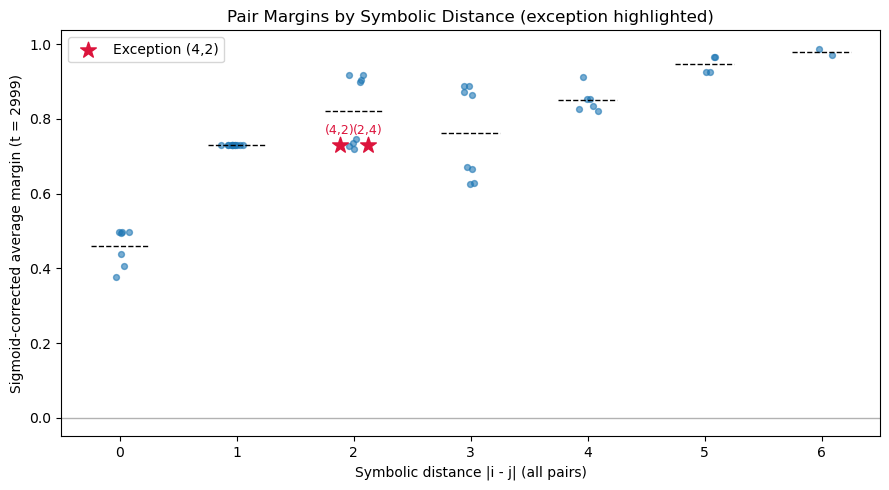

In [ ]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) using sigmoid_correct_margin_grid.

import numpy as np
import matplotlib.pyplot as plt

items_n = sigmoid_correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = sigmoid_correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = sigmoid_correct_margin_grid[p, q]
y_qp = sigmoid_correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Sigmoid-corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import csv

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step
# Additionally, save h1s and h2s activations (per time_step, item, unit) with per-seed values, mean, and std

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
train_dict = results["train"]

# Margins (training_progress): shape (seeds_n, time_steps, items_n, items_n)
training_progress = train_dict["training_progress"]
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header for margins
header_margins = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)

# Write margins CSV
csv_filename = f"conjunctive_lazy_rich.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header_margins)
    writer.writerows(rows)

print(f"Training pair results saved to {csv_filename}")

# Save h1s if available: shape (seeds_n, time_steps, items_n, h1_size)
if "h1s" in train_dict and train_dict["h1s"] is not None:
    h1s = train_dict["h1s"]
    h1_seeds, h1_time_steps, h1_items_n, h1_size = h1s.shape
    assert h1_seeds == seeds_n and h1_time_steps == time_steps and h1_items_n == items_n, "h1s shape mismatch"

    header_h1 = ["time_step", "item", "unit"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_activation", "std_activation"]
    rows_h1 = []
    for t in range(0, time_steps, 10):
        for i in range(items_n):
            for unit in range(h1_size):
                vals = h1s[:, t, i, unit]
                rows_h1.append([t, i, unit] + list(vals) + [vals.mean(), vals.std()])

    h1_csv_filename = f"conjunctive_lazy_rich_h1s.csv"
    with open(h1_csv_filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header_h1)
        writer.writerows(rows_h1)
    print(f"h1 activations saved to {h1_csv_filename}")
else:
    print("h1s not found in results['train']; skipping h1 CSV.")

# Save h2s if available: shape (seeds_n, time_steps, items_n, h2_size)
if "h2s" in train_dict and train_dict["h2s"] is not None:
    h2s = train_dict["h2s"]
    h2_seeds, h2_time_steps, h2_items_n, h2_size = h2s.shape
    if h2_seeds == seeds_n and h2_time_steps == time_steps and h2_items_n == items_n:
        header_h2 = ["time_step", "item", "unit"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_activation", "std_activation"]
        rows_h2 = []
        for t in range(0, time_steps, 10):
            for i in range(items_n):
                for unit in range(h2_size):
                    vals = h2s[:, t, i, unit]
                    rows_h2.append([t, i, unit] + list(vals) + [vals.mean(), vals.std()])

        h2_csv_filename = f"conjunctive_lazy_rich_h2s.csv"
        with open(h2_csv_filename, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header_h2)
            writer.writerows(rows_h2)
        print(f"h2 activations saved to {h2_csv_filename}")
    else:
        print("h2s shape mismatch with training_progress; skipping h2 CSV.")
else:
    print("h2s not found in results['train']; skipping h2 CSV.")

NameError: name 'results' is not defined

In [ ]:
csv_filename = f"conjunctive_lazy_rich.csv"
import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j        seed_0        seed_1        seed_2        seed_3  \
0          0  0  0  1.879169e-12 -7.554303e-14 -4.226780e-12  7.779239e-13   
1          1  0  0  1.885779e-12 -6.680636e-14 -4.213508e-12  7.718861e-13   
2          2  0  0  1.870533e-12 -7.202955e-14 -4.221947e-12  1.555590e-12   
3          3  0  0  1.847263e-12 -7.791784e-14 -4.235085e-12  6.741116e-13   
4          4  0  0  1.846703e-12  9.569079e-13 -7.810539e-12  6.740471e-13   

         seed_4        seed_5        seed_6        seed_7        seed_8  \
0 -7.472095e-13  1.050582e-12  2.372946e-12 -1.627288e-13  2.026661e-13   
1 -7.589691e-13  1.056879e-12  2.377201e-12 -1.669160e-13  2.005433e-13   
2 -3.908081e-12  1.061020e-12  2.369114e-12 -1.717142e-13  2.046477e-13   
3 -2.500786e-12  1.069176e-12  2.373262e-12 -1.895748e-13 -6.830811e-12   
4 -2.478479e-12  1.053709e-12  2.354476e-12 -2.072188e-13 -1.362484e-11   

         seed_9   mean_margin    std_margin  
0  8.2

Figure out keyerror on t issue

In [ ]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'mean_margin', 'std_margin']


In [ ]:
items_per_context = 7
p = 4
q = 2

if isinstance(results, tuple):
    results = results[1]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_progress.shape[1]-1, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))

# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


NameError: name 'results' is not defined

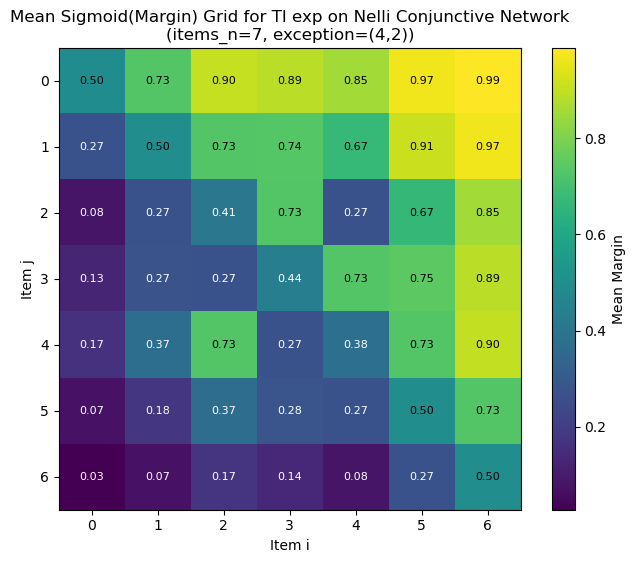

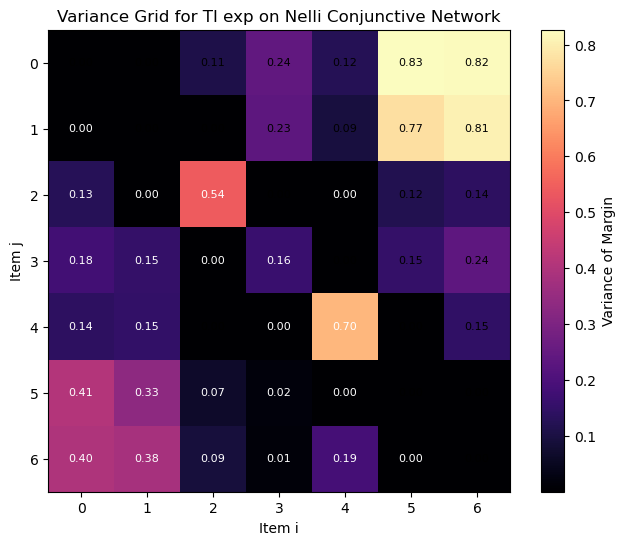

In [ ]:
# if isinstance(results, tuple):
    # results = results[1]
# training_progress = results["train"]["training_progress"]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_length - 1, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

Current directory: /share/ctn/users/lc3616/Nelli Reimplementation/conjunctive_lazy_rich_1e-5
Using directory: /share/ctn/users/lc3616/Nelli Reimplementation
csv_margin.py exists: True
Loaded data from CSV: 10 seeds, 3000 timesteps, 7 items
Exception items: [2, 3, 4]
Non-exception items: [0, 1, 5, 6]


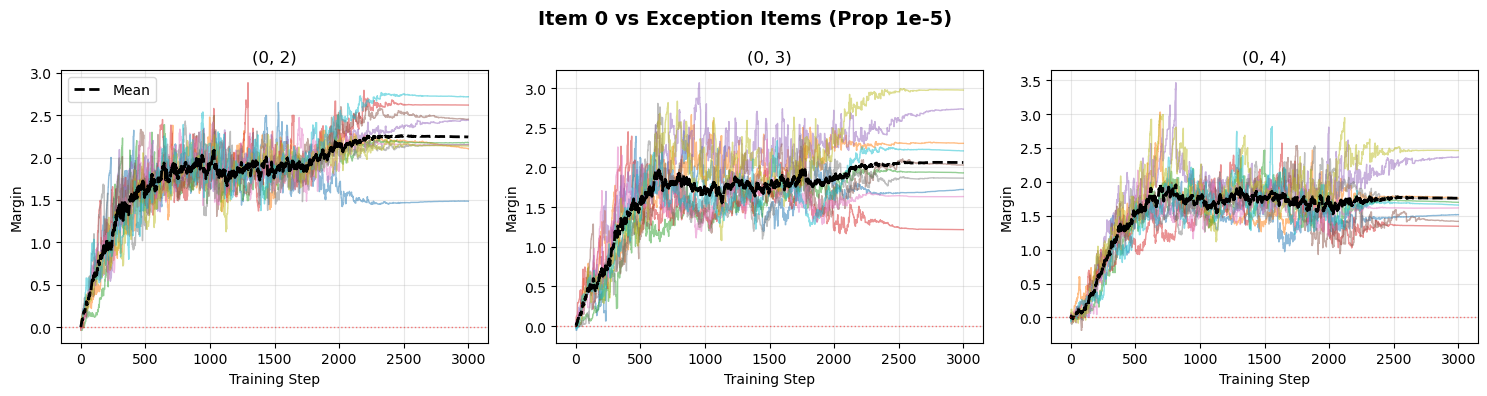

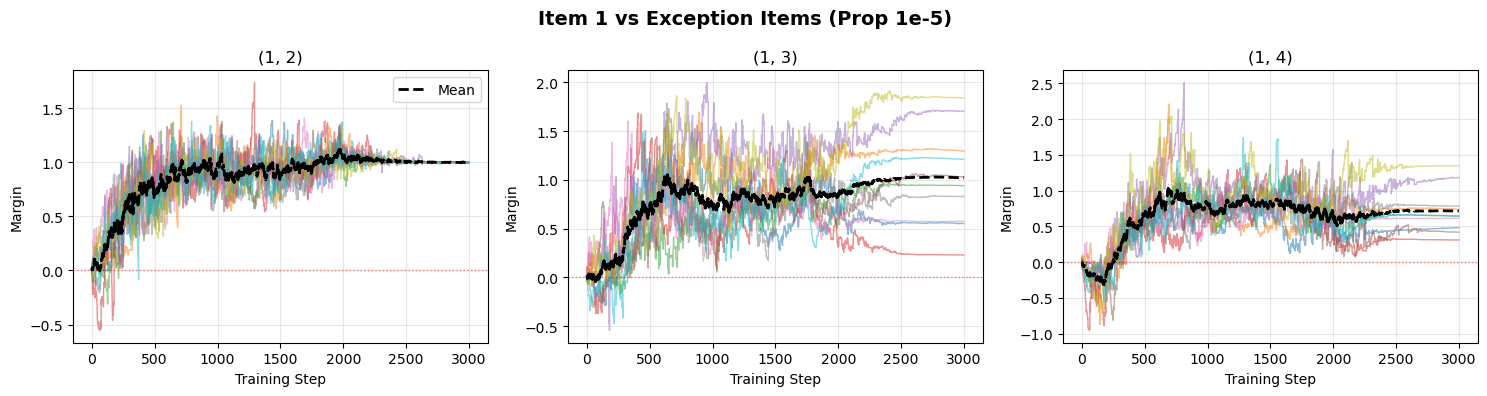

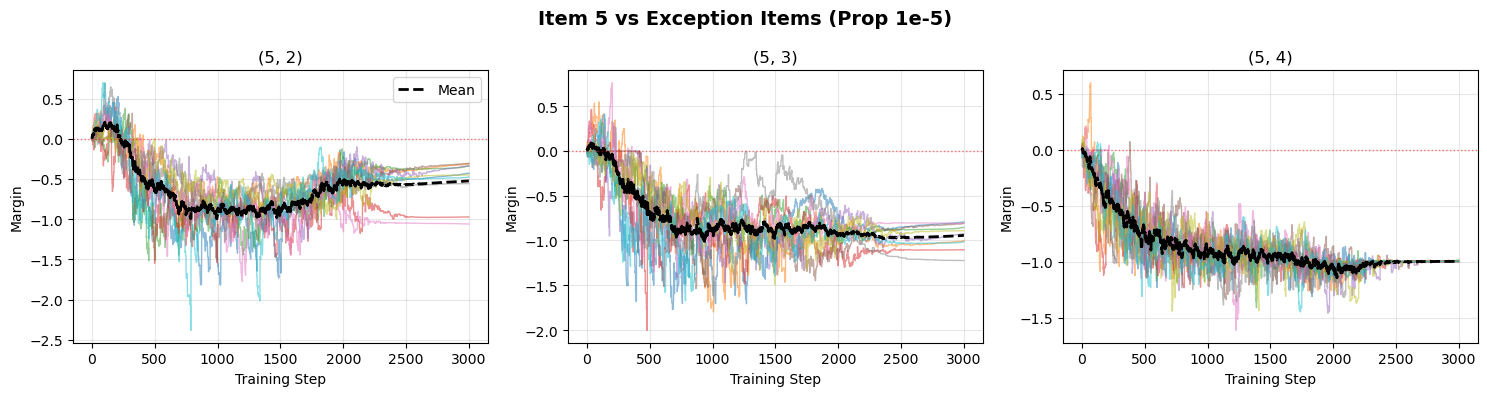

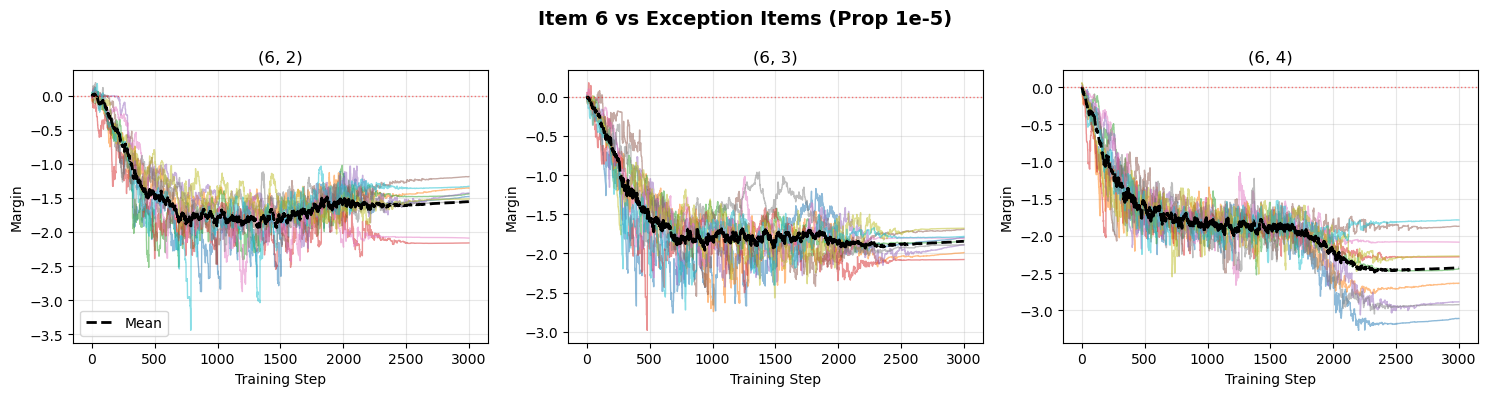

In [ ]:
# Plot each non-exception item vs each exception item
# Exception items: 2, 3, 4 (from p=4, q=2)
# Non-exception items: 0, 1, 5, 6

# Import MarginExtractor from parent directory
import sys
import os
import numpy as np

# Get the parent directory (where csv_margin.py should be)
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# If csv_margin.py is not in parent_dir, try current directory or set explicit path
if not os.path.exists(os.path.join(parent_dir, 'csv_margin.py')):
    # Check if it's in the current directory
    if os.path.exists(os.path.join(current_dir, 'csv_margin.py')):
        parent_dir = current_dir
    else:
        # Explicitly set to the Nelli Reimplementation directory
        parent_dir = r'Z:\Luke\Nelli Reimplementation'

print(f"Current directory: {current_dir}")
print(f"Using directory: {parent_dir}")
print(f"csv_margin.py exists: {os.path.exists(os.path.join(parent_dir, 'csv_margin.py'))}")

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from csv_margin import MarginExtractor
import pandas as pd

# Load the CSV file that was already created
csv_filename = "conjunctive_lazy_rich.csv"
df = pd.read_csv(csv_filename)

# Reconstruct training_progress from CSV (same as Cell 27)
t_col = 'time_step'
i_col = 'i'
j_col = 'j'

margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
csv_seeds_n = len(margin_cols)
csv_time_steps = df[t_col].max() + 1
csv_items_n = max(df[i_col].max(), df[j_col].max()) + 1

# Initialize training_progress array from CSV
training_progress_from_csv = np.zeros((csv_seeds_n, csv_time_steps, csv_items_n, csv_items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress_from_csv[s, t, i, j] = row[col]

# Create a mock results dict for MarginExtractor
results_from_csv = {
    "train": {
        "training_progress": training_progress_from_csv
    }
}

# Create MarginExtractor from CSV data
extractor = MarginExtractor(results_from_csv)
print(f"Loaded data from CSV: {csv_seeds_n} seeds, {csv_time_steps} timesteps, {csv_items_n} items")

# Define exception and non-exception items
p, q = 4, 2
exception_items = list(range(min(p, q), max(p, q) + 1))  # [2, 3, 4]
all_items = list(range(items_n))
non_exception_items = [i for i in all_items if i not in exception_items]

print(f"Exception items: {exception_items}")
print(f"Non-exception items: {non_exception_items}")

# Plot each non-exception item against each exception item
for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items (Prop 1e-5)", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Plot margin over time for each seed
        for seed in range(seeds_n):
            # Get margin for (non_exc, exc)
            margin_data = extractor.training_progress[seed, :, non_exc, exc]
            ax.plot(margin_data, alpha=0.5, linewidth=1)
        
        # Calculate mean and plot
        mean_margin = extractor.training_progress[:, :, non_exc, exc].mean(axis=0)
        ax.plot(mean_margin, color='black', linewidth=2, label='Mean', linestyle='--')
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.5)
        
    axes[0].legend()
    plt.tight_layout()
    plt.show()


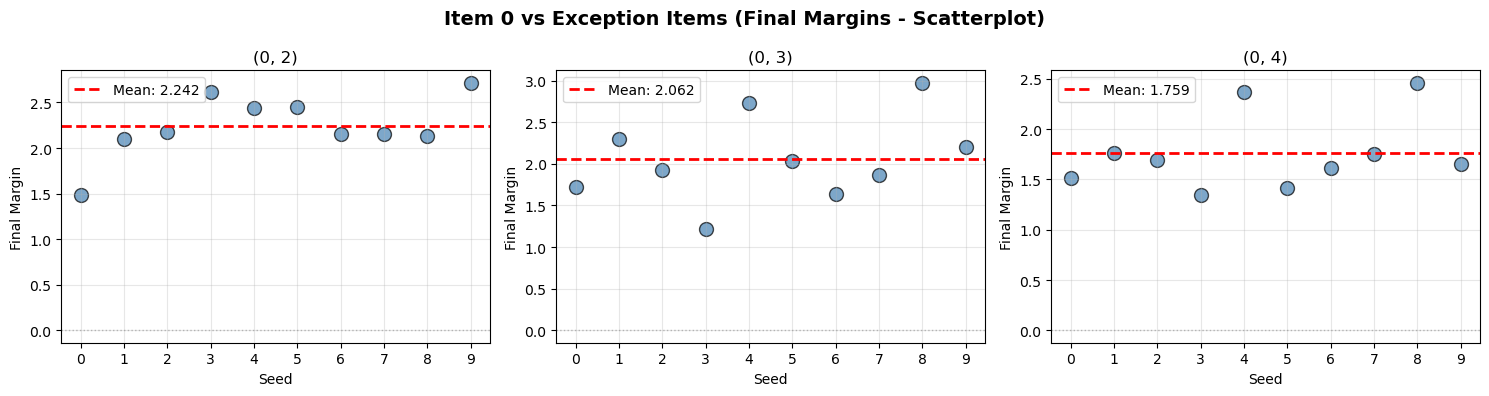

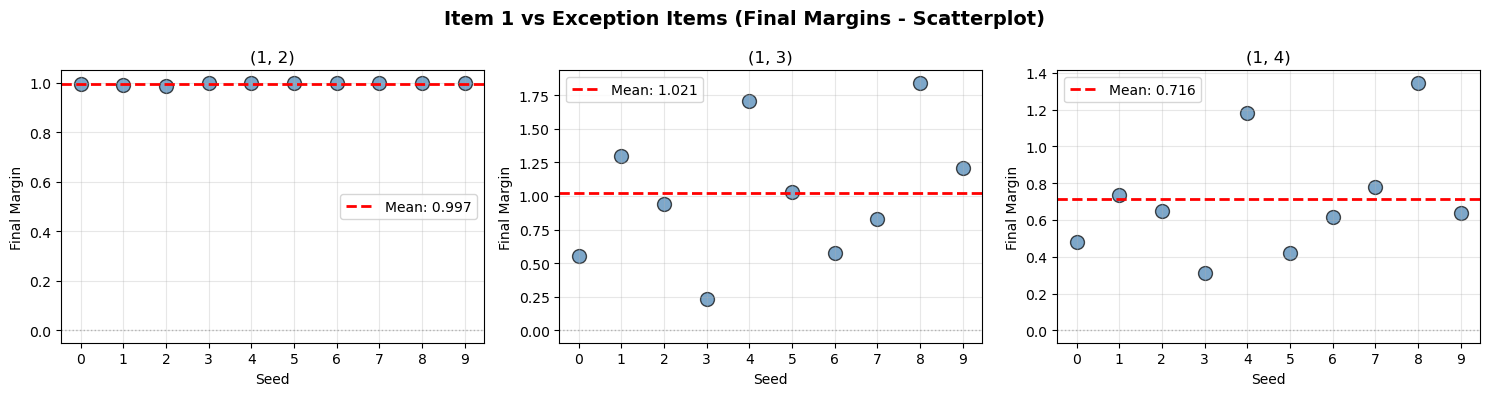

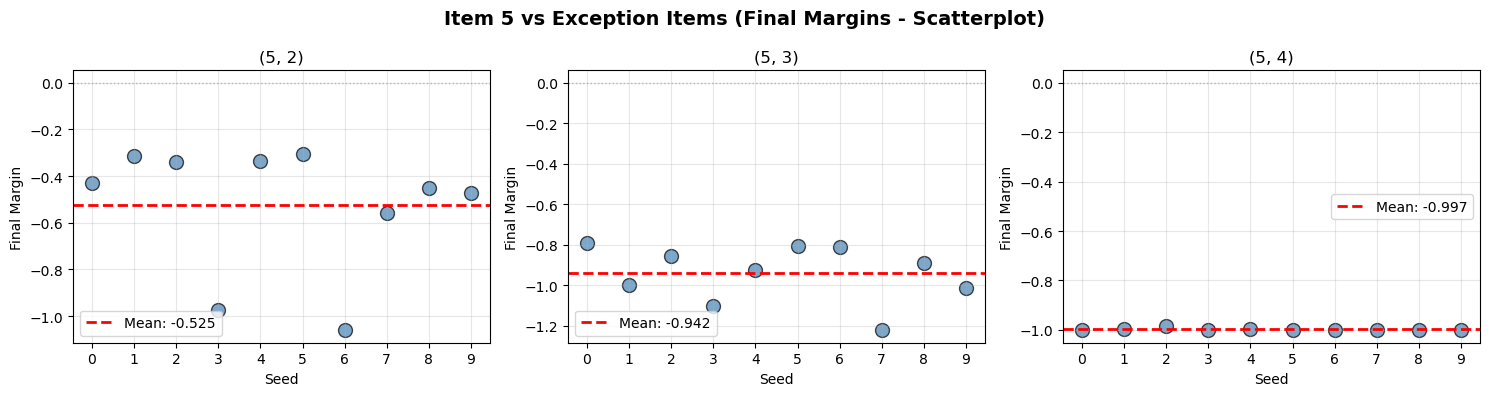

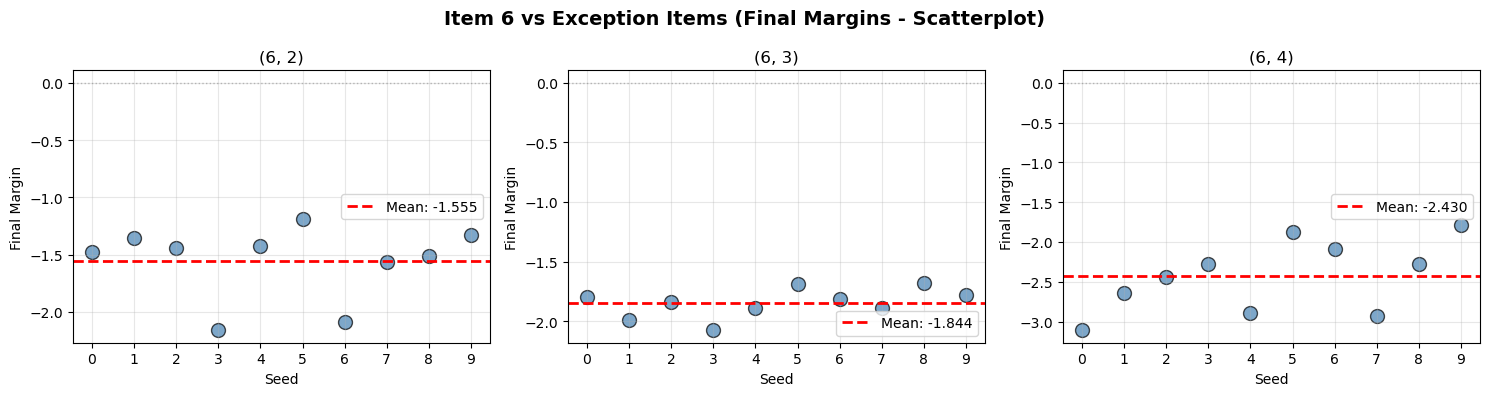

In [ ]:
# Scatterplot version - showing final margins for non-exception vs exception items
# Reuse the same exception/non-exception item definitions

# Get final timestep margins
final_timestep = extractor.time_steps - 1

for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items (Final Margins - Scatterplot)", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Get final margins for all seeds for pair (non_exc, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc, exc]
        
        # Create scatter plot with seed indices on x-axis
        seeds = np.arange(csv_seeds_n)
        ax.scatter(seeds, final_margins, s=100, alpha=0.7, c='steelblue', edgecolors='black', linewidth=1)
        
        # Add mean line
        mean_margin = final_margins.mean()
        ax.axhline(y=mean_margin, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_margin:.3f}')
        
        # Add zero reference line
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        ax.set_xlabel('Seed')
        ax.set_ylabel('Final Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.set_xticks(seeds)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
    plt.tight_layout()
    plt.show()


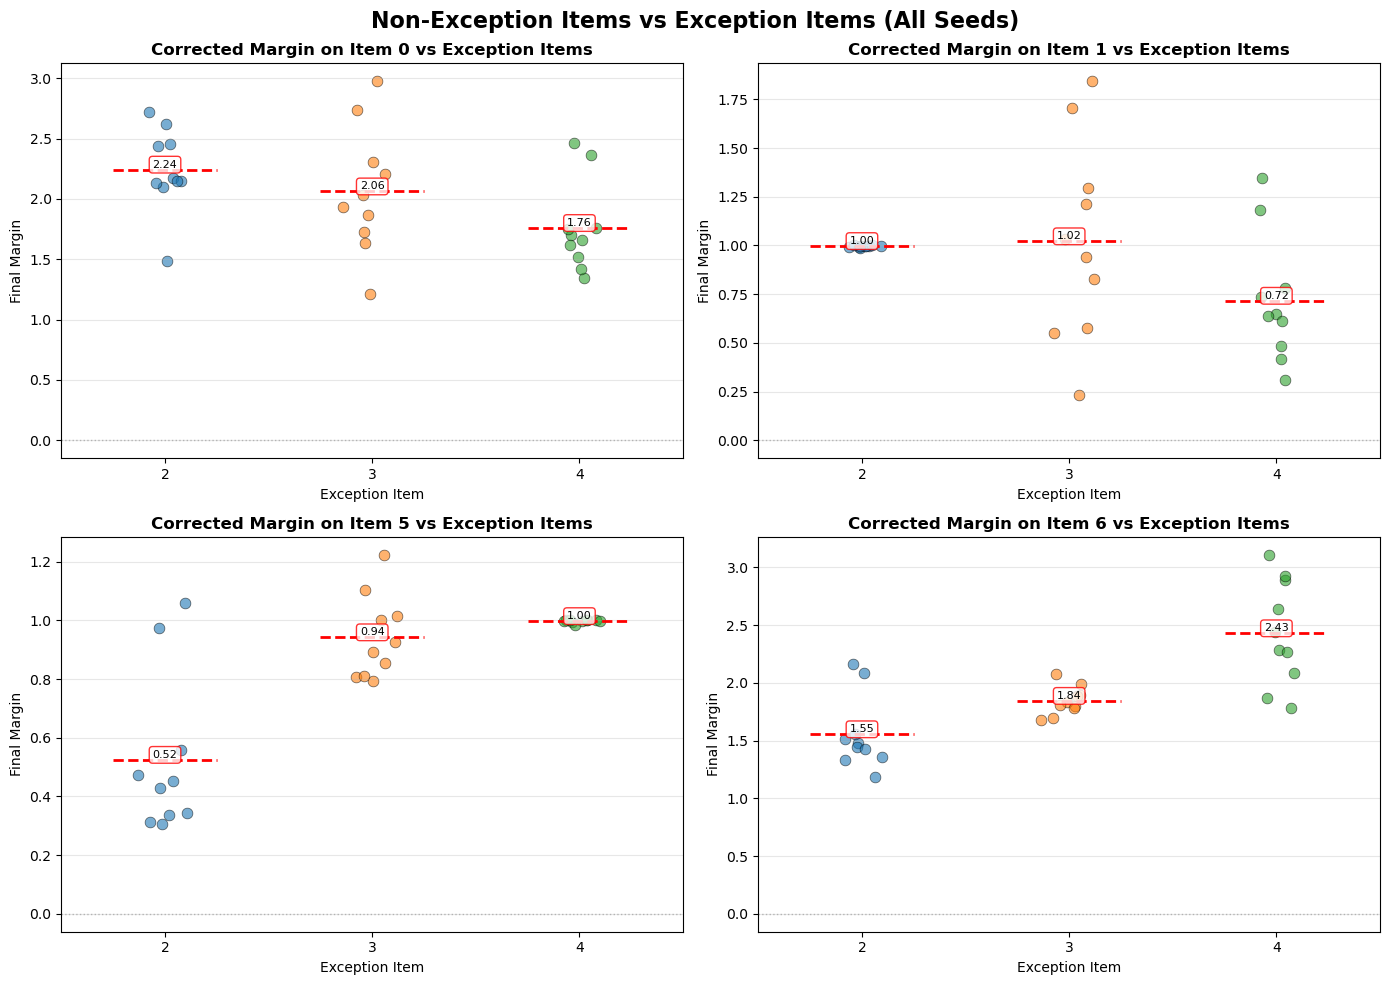

In [ ]:
# Combined scatter plot: all non-exception items vs exception items in one figure
# X-axis: exception item index (2, 3, 4)
# Y-axis: final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items (All Seeds)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins.size)
        ax.scatter(x, final_margins, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.2f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Final Margin')
    ax.set_title(f'Corrected Margin on Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


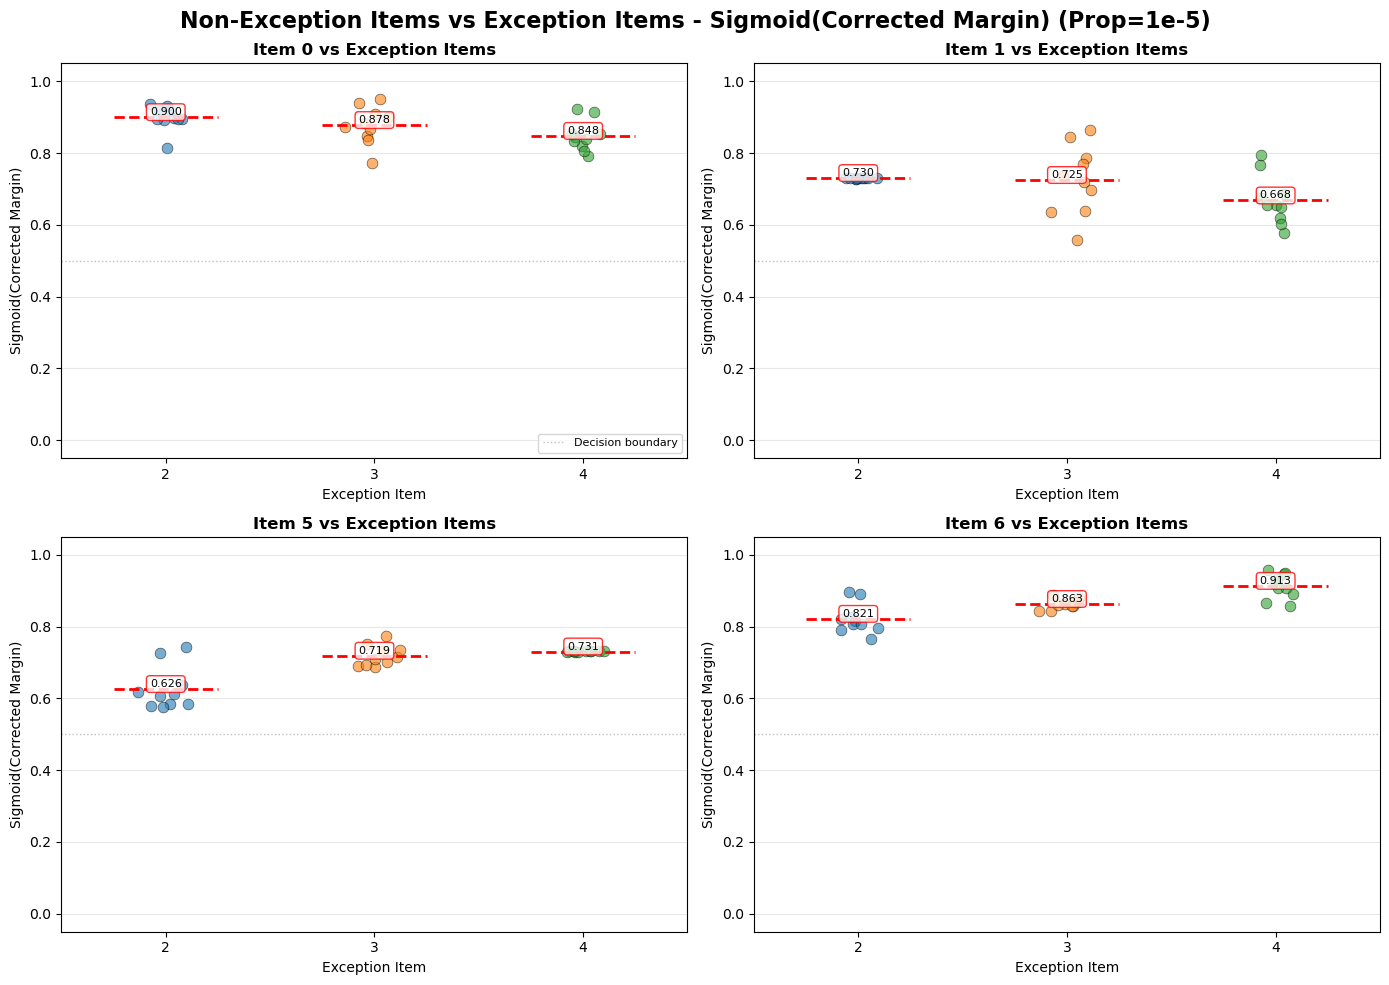

In [ ]:
# Combined scatter plot with SIGMOID(corrected margins)
# X-axis: exception item index (2, 3, 4)
# Y-axis: sigmoid of final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items - Sigmoid(Corrected Margin) (Prop=1e-5)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Apply sigmoid transformation
        final_margins_sigmoid = 1 / (1 + np.exp(-final_margins))
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins_sigmoid.size)
        ax.scatter(x, final_margins_sigmoid, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins_sigmoid.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.3f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Sigmoid(Corrected Margin)')
    ax.set_title(f'Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0.5, color='gray', linewidth=1, linestyle=':', alpha=0.5, label='Decision boundary')
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()


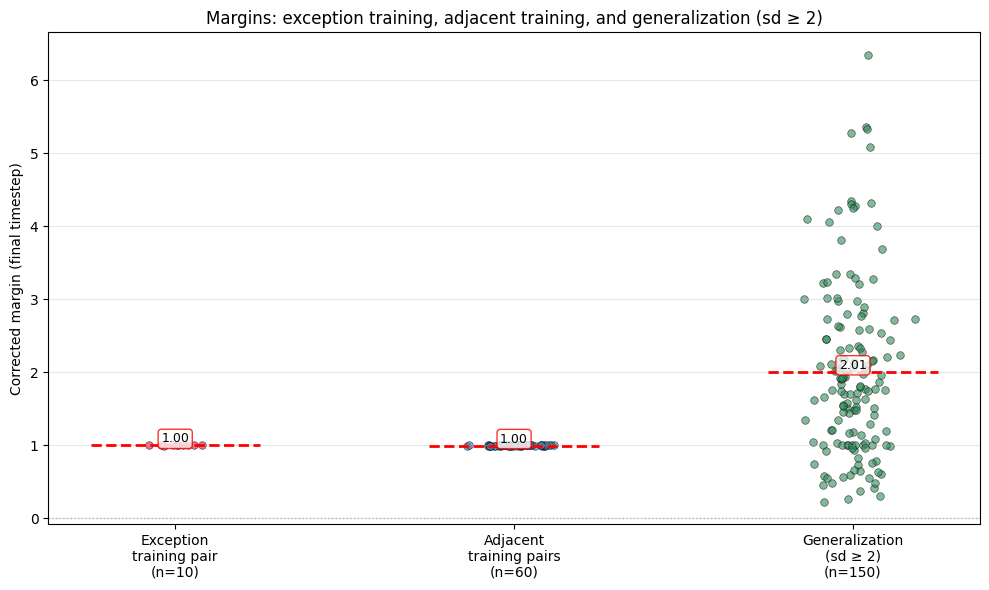

In [ ]:
# Margins for exception training pair, adjacent training pairs, and generalization pairs (sd ≥ 2)

# Build extractor from CSV to make this cell self-contained
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure we can import MarginExtractor
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from csv_margin import MarginExtractor

# Load CSV written earlier in the notebook
csv_filename = "conjunctive_lazy_rich.csv"
df = pd.read_csv(csv_filename)

# Reconstruct training_progress from the CSV (same logic as earlier)
t_col, i_col, j_col = 'time_step', 'i', 'j'
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
csv_seeds_n = len(margin_cols)
csv_time_steps = df[t_col].max() + 1
csv_items_n = max(df[i_col].max(), df[j_col].max()) + 1

training_progress = np.zeros((csv_seeds_n, csv_time_steps, csv_items_n, csv_items_n))
for _, row in df.iterrows():
    t = int(row[t_col]); i = int(row[i_col]); j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

results_from_csv = {"train": {"training_progress": training_progress}}
extractor = MarginExtractor(results_from_csv)

# Exception definition
p, q = 4, 2

# Ensure we have the final timestep and items count
final_timestep = extractor.time_steps - 1
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]

# Use unordered pairs by taking only i < j and define categories by symbolic distance (sd = |i - j|)
exc_unordered = (min(p, q), max(p, q))  # the single exception training pair (unordered)

training_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                  if abs(i - j) == 1 and (i, j) != exc_unordered]

exception_pairs = [exc_unordered]

generalization_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                        if abs(i - j) >= 2]

# Helper to get corrected margins across seeds for a single (i, j) with i < j
# Flip the exception pair so it aligns with the "corrected" convention used elsewhere

def corrected_seed_margins(i, j):
    vals = extractor.training_progress[:, final_timestep, i, j]
    if (i, j) == exc_unordered:
        vals = -vals
    return vals

# Collect margins for a set of pairs (concatenate all seeds across all pairs)

def collect_margins(pairs):
    if len(pairs) == 0:
        return np.array([])
    all_vals = [corrected_seed_margins(i, j) for (i, j) in pairs]
    return np.concatenate(all_vals, axis=0)

exception_margins = collect_margins(exception_pairs)
training_margins = collect_margins(training_pairs)
generalization_margins = collect_margins(generalization_pairs)

# Jittered scatter per category with mean lines
rng = np.random.default_rng(0)

categories = ["Exception\ntraining pair", "Adjacent\ntraining pairs", "Generalization\n(sd ≥ 2)"]
values = [exception_margins, training_margins, generalization_margins]
colors = ['crimson', 'steelblue', 'seagreen']

plt.figure(figsize=(10, 6))
for idx, (vals, color) in enumerate(zip(values, colors)):
    if vals.size == 0:
        continue
    x = rng.normal(loc=idx, scale=0.06, size=vals.size)
    plt.scatter(x, vals, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color=color)
    mean_val = vals.mean()
    plt.hlines(mean_val, idx - 0.25, idx + 0.25, colors='red', linestyles='--', linewidth=2)
    plt.text(idx, mean_val, f"{mean_val:.2f}", ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='red', alpha=0.8))

plt.xticks(range(len(categories)), [f"{label}\n(n={len(v)})" for label, v in zip(categories, values)])
plt.ylabel('Corrected margin (final timestep)')
plt.title('Margins: exception training, adjacent training, and generalization (sd ≥ 2)')
plt.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


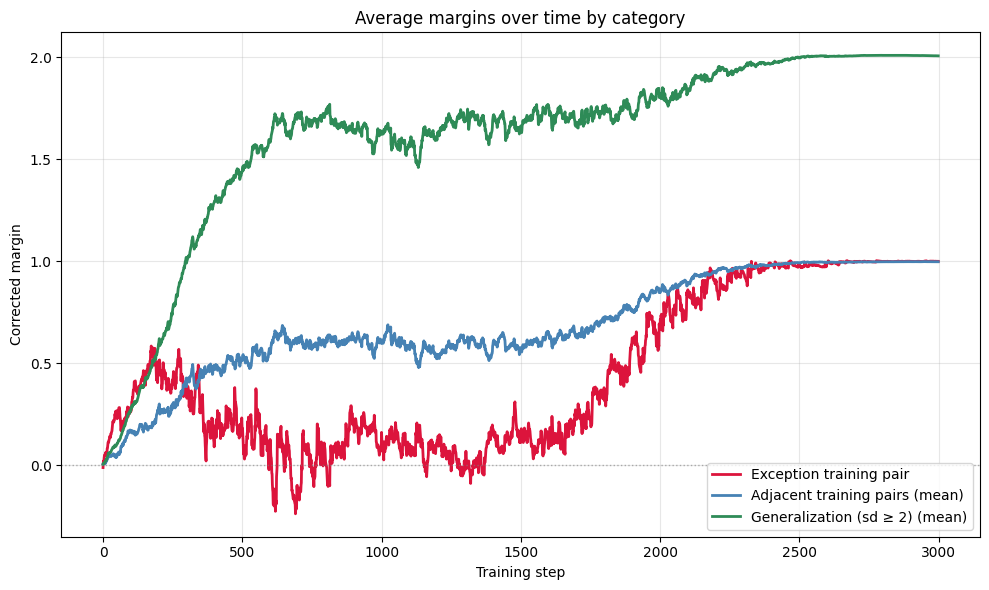

In [ ]:
# Average category margins over time: exception training, adjacent training, generalization (sd ≥ 2)
import numpy as np
import matplotlib.pyplot as plt

# Assume extractor, p, q exist from previous cell
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]
time_steps = extractor.time_steps
seeds_n = extractor.seeds_n

# Define unordered exception pair and category sets using i < j canonical orientation
exc_unordered = (min(p, q), max(p, q))
training_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                  if abs(i - j) == 1 and (i, j) != exc_unordered]
exception_pairs = [exc_unordered]
generalization_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                        if abs(i - j) >= 2]

# Helpers to gather corrected margins at time t for a category

def corrected_margins_at_t(i, j, t):
    vals = extractor.training_progress[:, t, i, j]
    # Flip the exception pair so it aligns with the "corrected" convention
    if (i, j) == exc_unordered:
        vals = -vals
    return vals


def category_mean_series(pairs):
    means = np.zeros(time_steps)
    if len(pairs) == 0:
        return means
    for t in range(time_steps):
        all_vals_t = []
        for (i, j) in pairs:
            all_vals_t.append(corrected_margins_at_t(i, j, t))  # shape: (seeds,)
        cat_vals_t = np.concatenate(all_vals_t, axis=0)  # concat over pairs and seeds
        means[t] = cat_vals_t.mean()
    return means

exc_series = category_mean_series(exception_pairs)
train_series = category_mean_series(training_pairs)
gen_series = category_mean_series(generalization_pairs)

plt.figure(figsize=(10, 6))
plt.plot(exc_series, label='Exception training pair', color='crimson', linewidth=2)
plt.plot(train_series, label='Adjacent training pairs (mean)', color='steelblue', linewidth=2)
plt.plot(gen_series, label='Generalization (sd ≥ 2) (mean)', color='seagreen', linewidth=2)
plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.6)
plt.xlabel('Training step')
plt.ylabel('Corrected margin')
plt.title('Average margins over time by category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


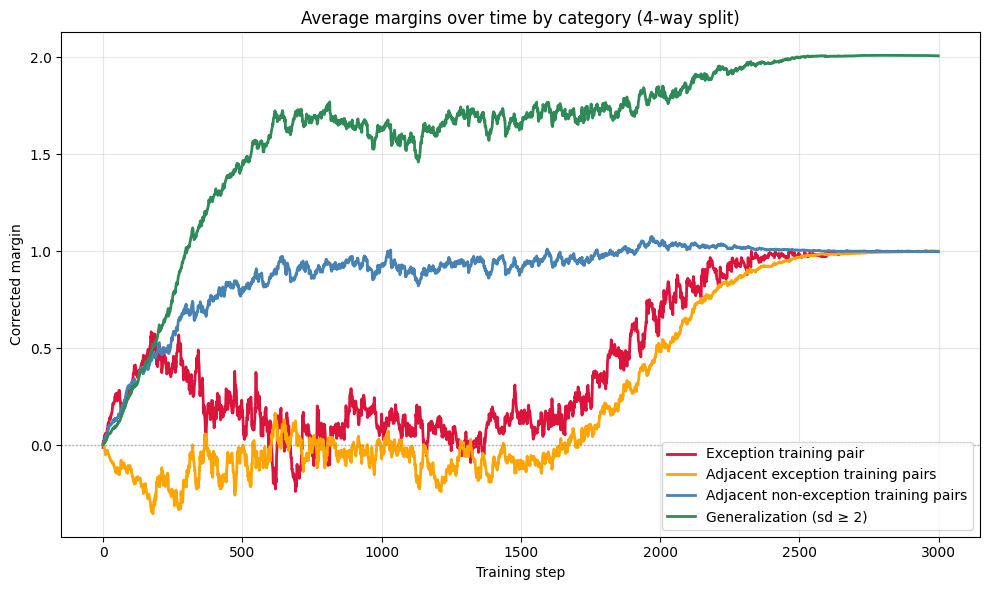

In [ ]:
# Average category margins over time (4 categories):
# 1) Exception training pair
# 2) Adjacent exception training pairs (within exception band)
# 3) Adjacent non-exception training pairs (outside exception band)
# 4) Generalization pairs (sd ≥ 2)
import numpy as np
import matplotlib.pyplot as plt

# Assume extractor, p, q exist from previous cell
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]
time_steps = extractor.time_steps

exc_unordered = (min(p, q), max(p, q))
exception_items = list(range(min(p, q), max(p, q) + 1))

# Build categories using canonical orientation i < j
exception_pair = [exc_unordered]

adjacent_exception_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) == 1 and (i in exception_items and j in exception_items)
]

adjacent_nonexception_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) == 1 and not (i in exception_items and j in exception_items)
]

generalization_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) >= 2
]

# Helpers

def corrected_margins_at_t(i, j, t):
    vals = extractor.training_progress[:, t, i, j]
    # Flip the exception pair to align with the "corrected" convention
    if (i, j) == exc_unordered:
        vals = -vals
    return vals


def category_mean_series(pairs):
    means = np.zeros(time_steps)
    if len(pairs) == 0:
        return means
    for t in range(time_steps):
        all_vals_t = [corrected_margins_at_t(i, j, t) for (i, j) in pairs]
        cat_vals_t = np.concatenate(all_vals_t, axis=0)
        means[t] = cat_vals_t.mean()
    return means

exc_series = category_mean_series(exception_pair)
adj_exc_series = category_mean_series(adjacent_exception_pairs)
adj_nonexc_series = category_mean_series(adjacent_nonexception_pairs)
gen_series = category_mean_series(generalization_pairs)

plt.figure(figsize=(10, 6))
plt.plot(exc_series, label='Exception training pair', color='crimson', linewidth=2)
plt.plot(adj_exc_series, label='Adjacent exception training pairs', color='orange', linewidth=2)
plt.plot(adj_nonexc_series, label='Adjacent non-exception training pairs', color='steelblue', linewidth=2)
plt.plot(gen_series, label='Generalization (sd ≥ 2)', color='seagreen', linewidth=2)
plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.6)
plt.xlabel('Training step')
plt.ylabel('Corrected margin')
plt.title('Average margins over time by category (4-way split)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("adjacent_nonexception_pairs:", adjacent_nonexception_pairs)
print("adjacent_exception_pairs:", adjacent_exception_pairs)
print("exception_pair:", exception_pair)
print("generalization_pairs:", generalization_pairs)

adjacent_nonexception_pairs: [(0, 1), (1, 2), (4, 5), (5, 6)]
adjacent_exception_pairs: [(2, 3), (3, 4)]
exception_pair: [(2, 4)]
generalization_pairs: [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 5), (3, 6), (4, 6)]


In [ ]:
# Neural Knowledge Assembly-style visualization adapted to this network
# - Top row: Euclidean distance matrices of hidden layer h1s at 3 training positions
# - Bottom row: 2D MDS embeddings at the same positions

import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances

# Unwrap results if needed and verify presence of h1s
if isinstance(results, tuple):
    results = results[1]

if "train" not in results or "h1s" not in results["train"]:
    print("No hidden activations (h1s) found in results['train']. Run training first.")
else:
    # Average over seeds: shape becomes (time_steps, items_n, h1_size)
    all_h1s = np.mean(results["train"]["h1s"], axis=0)
    steps_after_training = all_h1s.shape[0] - 1

    # Choose three positions across training
    positions = [0.10, 0.25, 1.00]

    fig, axs = plt.subplots(2, 3, figsize=(8., 5), constrained_layout=True)
    fig.patch.set_facecolor('white')

    # Determine vmax across selected time slices
    vmax = 0.0
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        h1s = all_h1s[t_idx]
        vmax_ = np.round(np.max(euclidean_distances(h1s)), 1)
        if vmax_ > vmax:
            vmax = vmax_

    # Top row: distance matrices
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        dists = euclidean_distances(all_h1s[t_idx])
        im = matrix_plot(dists, axs[0, i], items_n, 0., vmax)
        axs[0, i].set_title(f"step {t_idx+1}", pad=15)

    cbar = fig.colorbar(im, ax=axs[0, i], anchor=(0., 0.5), shrink=.4, aspect=7.)
    cbar.set_ticks([])
    cbar.ax.text(.7, vmax*1.22, vmax, ha='center', va='center')
    cbar.ax.text(.5, -0.25, 0, ha='center', va='center')
    cbar.set_label("a.u.")
    cbar.outline.set_edgecolor([0.5] * 3)

    # Bottom row: MDS embeddings
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        dists = euclidean_distances(all_h1s[t_idx])
        mds = manifold.MDS(n_components=2, eps=1e-9, dissimilarity="precomputed", random_state=mds_seed,
                           normalized_stress="auto")
        d1, d2 = mds.fit(dists).embedding_.T

        # Apply small rotation tweaks for consistent orientation
        if i == 0:
            rotate(d1, d2, 250.)
        elif i == 1:
            rotate(d1, d2, 230.)
        else:
            rotate(d1, d2, 260.)

        mds_plot((d1, d2), axs[1, i], items_n)
        lim = 0.50
        axs[1, i].set_xlim(-lim, lim)
        axs[1, i].set_ylim(-lim, lim)
        axs[1, i].set_xticks([-0.5, 0.5])
        axs[1, i].set_yticks([-0.5, 0.5])

        # Set border style
        for pos in ["left", "bottom"]:
            axs[1, i].spines[pos].set_linewidth(1)
            axs[1, i].spines[pos].set_color([0.5]*3)

        axs[1, i].set_xlabel("dimension 1\na.u.", labelpad=-6.)
        axs[1, i].set_ylabel("dimension 2", labelpad=-11.)

    plt.show()


In [ ]:
# Neural Knowledge Assembly-style visualization for h2s (second-layer representations)
# - Top row: Euclidean distance matrices of h2s at 3 training positions
# - Bottom row: 2D MDS embeddings at the same positions

import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances

# Unwrap results if needed and verify presence of h2s
if isinstance(results, tuple):
    results = results[1]

train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict:
    print("No h2s found in results['train']. To enable this, log h2s during training, e.g.:\n"
          "results['train']['h2s'][seed, training_step] = model.extract_h2s()")
else:
    # Average over seeds: expected shape (time_steps, items_n, h2_size)
    all_h2s = np.mean(train_dict["h2s"], axis=0)
    time_steps, items_n_inferred, _ = all_h2s.shape

    # Choose three positions across training (same as h1s plot)
    positions = [0.10, 0.25, 1.00]
    steps_after_training = time_steps - 1

    fig, axs = plt.subplots(2, 3, figsize=(8., 5), constrained_layout=True)
    fig.patch.set_facecolor('white')

    # Determine vmax across selected time slices to normalize color scale
    vmax = 0.0
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        h2s = all_h2s[t_idx]
        vmax_ = np.round(np.max(euclidean_distances(h2s)), 1)
        if vmax_ > vmax:
            vmax = vmax_

    # Top row: distance matrices of h2s
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        dists = euclidean_distances(all_h2s[t_idx])
        im = matrix_plot(dists, axs[0, i], items_n_inferred, 0., vmax)
        axs[0, i].set_title(f"h2s — step {t_idx+1}", pad=15)

    cbar = fig.colorbar(im, ax=axs[0, i], anchor=(0., 0.5), shrink=.4, aspect=7.)
    cbar.set_ticks([])
    cbar.ax.text(.7, vmax*1.22, vmax, ha='center', va='center')
    cbar.ax.text(.5, -0.25, 0, ha='center', va='center')
    cbar.set_label("a.u.")
    cbar.outline.set_edgecolor([0.5] * 3)

    # Bottom row: MDS embeddings from h2s distances
    for i in range(3):
        t_idx = max(0, int(positions[i] * steps_after_training))
        dists = euclidean_distances(all_h2s[t_idx])
        mds = manifold.MDS(n_components=2, eps=1e-9, dissimilarity="precomputed", random_state=mds_seed,
                           normalized_stress="auto")
        d1, d2 = mds.fit(dists).embedding_.T

        # Same cosmetic orientation alignment as earlier
        if i == 0:
            rotate(d1, d2, 250.)
        elif i == 1:
            rotate(d1, d2, 230.)
        else:
            rotate(d1, d2, 260.)

        mds_plot((d1, d2), axs[1, i], items_n_inferred)
        lim = 0.50
        axs[1, i].set_xlim(-lim, lim)
        axs[1, i].set_ylim(-lim, lim)
        axs[1, i].set_xticks([-0.5, 0.5])
        axs[1, i].set_yticks([-0.5, 0.5])

        for pos in ["left", "bottom"]:
            axs[1, i].spines[pos].set_linewidth(1)
            axs[1, i].spines[pos].set_color([0.5]*3)

        axs[1, i].set_xlabel("dimension 1\na.u.", labelpad=-6.)
        axs[1, i].set_ylabel("dimension 2", labelpad=-11.)

    plt.show()
